# *TSR - 99%*

## 导入库

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# import keras

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## 数据集路径

In [3]:
data_dir = './datasets'
train_path = './datasets/Train'
test_path = './datasets/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## 数据集种类

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# 标签
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## 数据集可视化

In [6]:
df = pd.read_csv('./datasets/Meta.csv')
df_sorted = df.sort_values(by='ClassId', ascending=True).reset_index(drop=True)
print(df_sorted.head(10))

         Path  ClassId  ShapeId  ColorId SignId
0  Meta/0.png        0        1        0   3.29
1  Meta/1.png        1        1        0   3.29
2  Meta/2.png        2        1        0   3.29
3  Meta/3.png        3        1        0   3.29
4  Meta/4.png        4        1        0   3.29
5  Meta/5.png        5        1        0   3.29
6  Meta/6.png        6        1        3    3.3
7  Meta/7.png        7        1        0   3.29
8  Meta/8.png        8        1        0   3.29
9  Meta/9.png        9        1        0   3.25


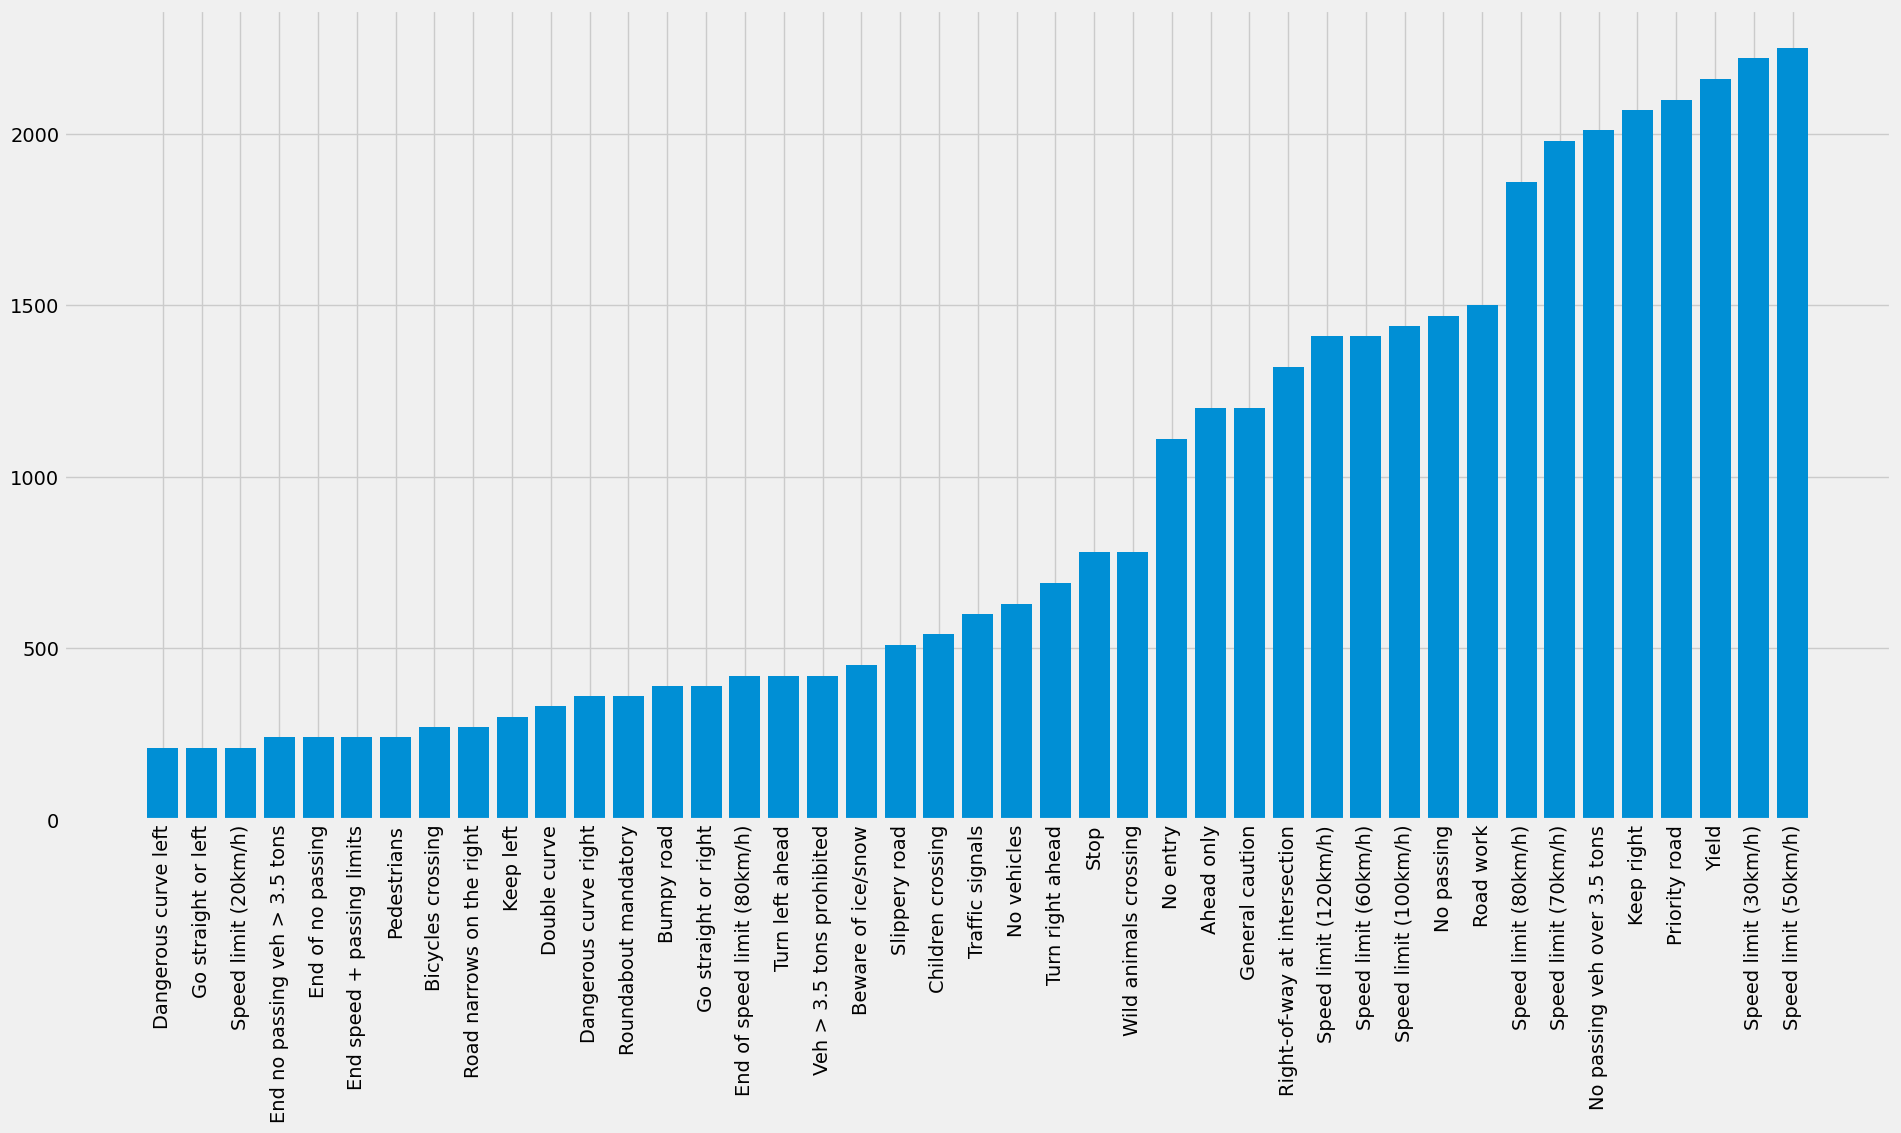

In [7]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]


plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


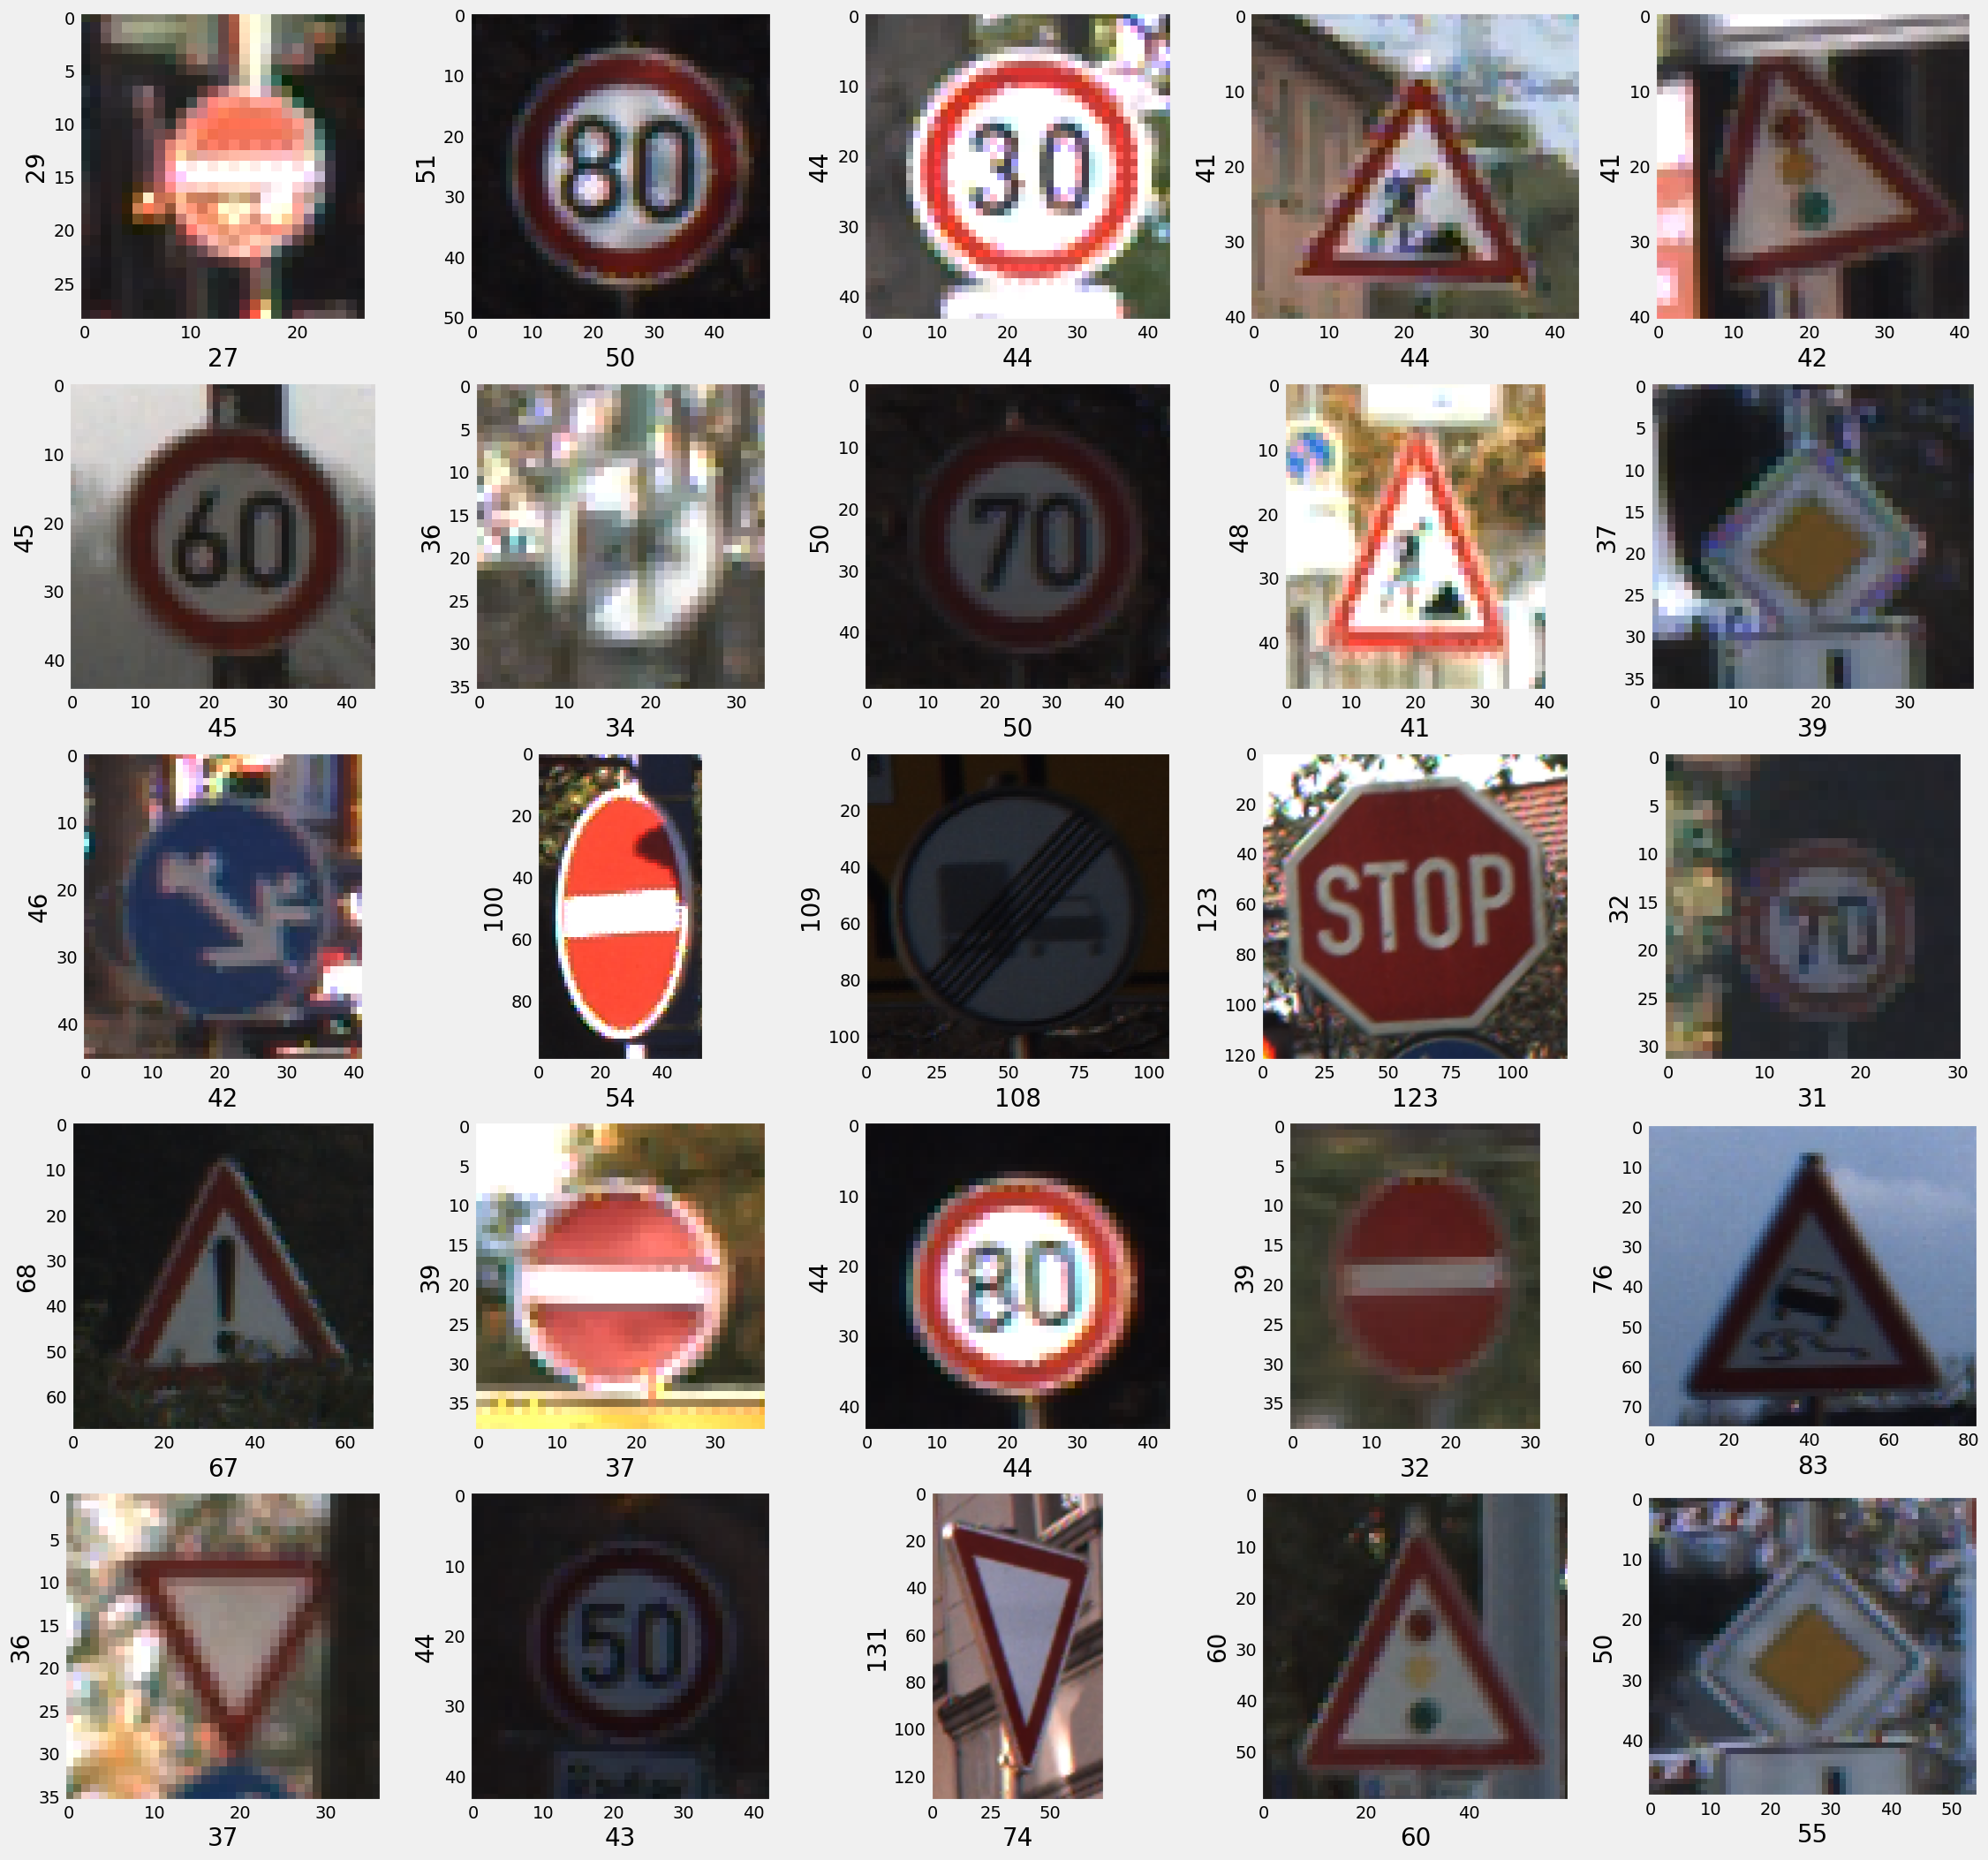

In [8]:
# 随机显示 25 张测试集图片
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## 图片处理

In [9]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## 打乱训练集

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## 训练集 验证集

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## 热编码

In [12]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## 模型

In [13]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25), 
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
#     keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
#     keras.layers.Dense(43, activation='rule')
])

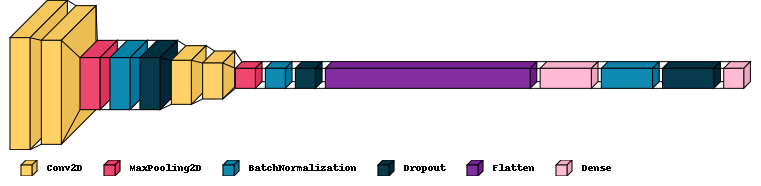

In [33]:
import visualkeras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten

# 优化可视化
visualkeras.layered_view(model, 
                         to_file='optimized_model.png',  # 输出文件名
                         legend=True,                    # 显示图例
                         color_map={                      # 自定义颜色映射
                             'Conv2D': 'orange', 
                             'MaxPool2D': 'lightblue', 
                             'Dense': 'green', 
                             'BatchNormalization': 'purple', 
                             'Dropout': 'red',
                         },
                         draw_volume=True)               



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         7

In [15]:
lr = 0.001
epochs = 100
batch_size = 256

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



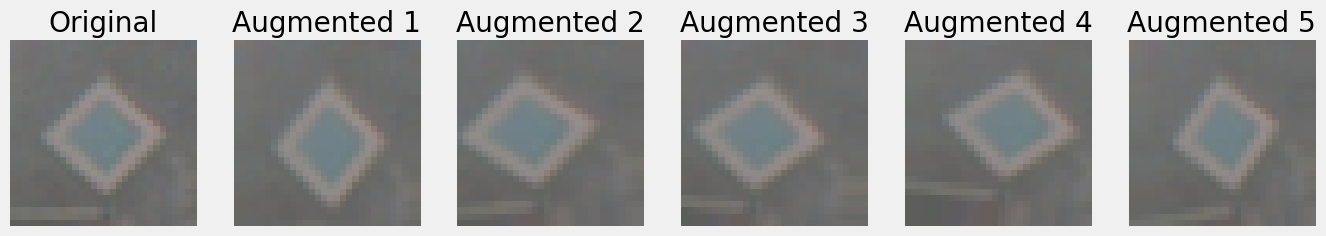

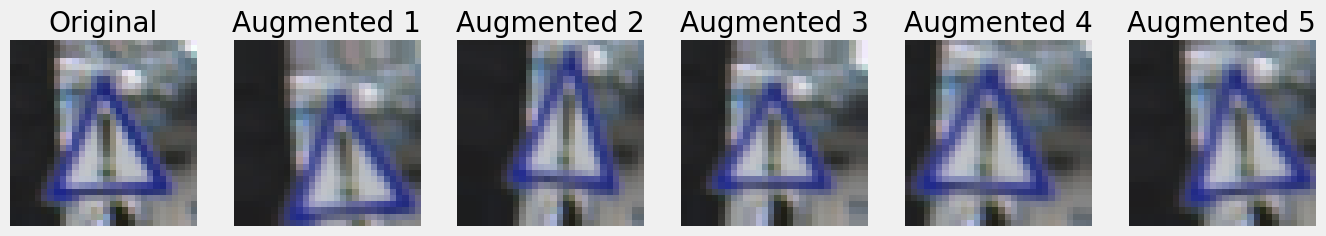

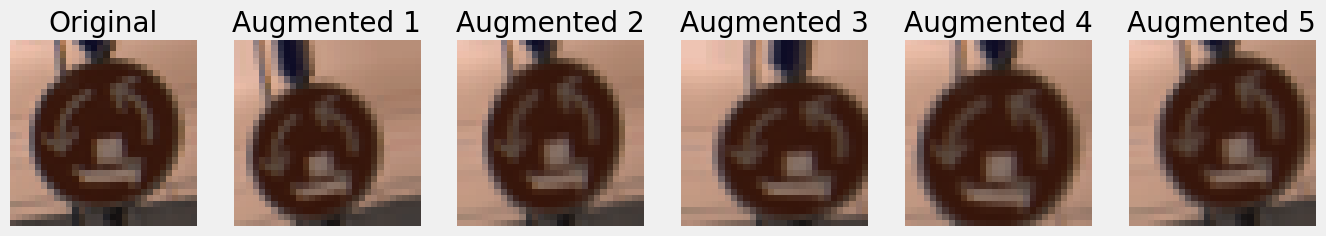

In [23]:
import random

def visualize_augmentation(image, augmenter, num_augmented=5):
    """
    显示原始图像及其数据增强后的版本
    """
    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    for i in range(num_augmented):
        augmented_img = augmenter.random_transform(image)
        plt.subplot(1, num_augmented + 1, i + 2)
        plt.imshow(augmented_img)
        plt.title("Augmented " + str(i + 1))
        plt.axis('off')
    plt.show()

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
                        )     

# 随机选择三张图像进行增强
random_indices = random.sample(range(len(X_train)), 3)  # 随机选择3个索引

for idx in random_indices:
    sample_image = X_train[idx]  # 获取随机选中的图像
    visualize_augmentation(sample_image, aug)  # 进行数据增强并展示


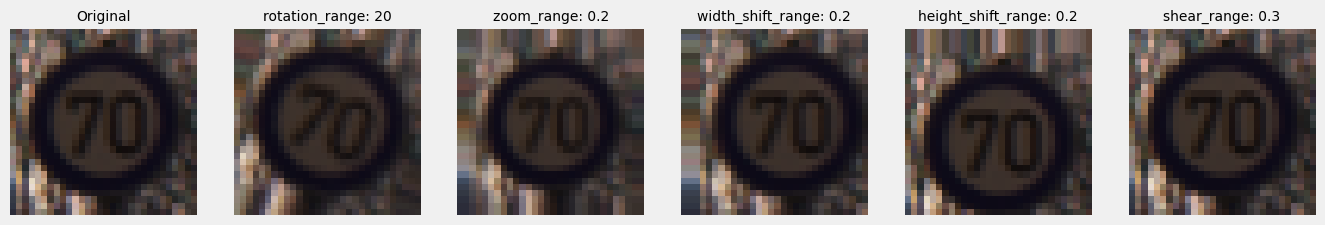

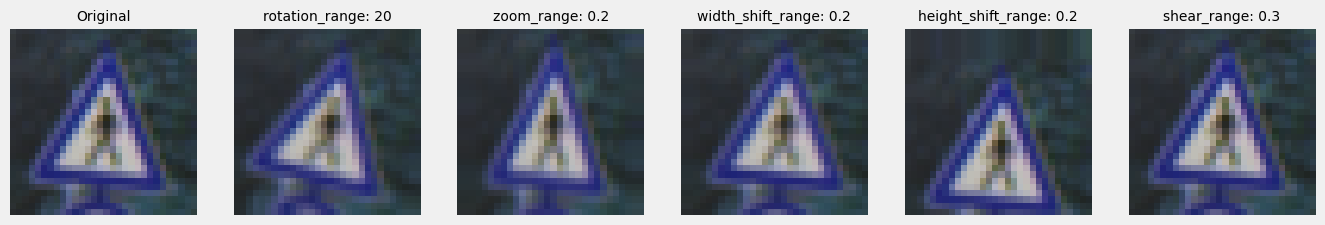

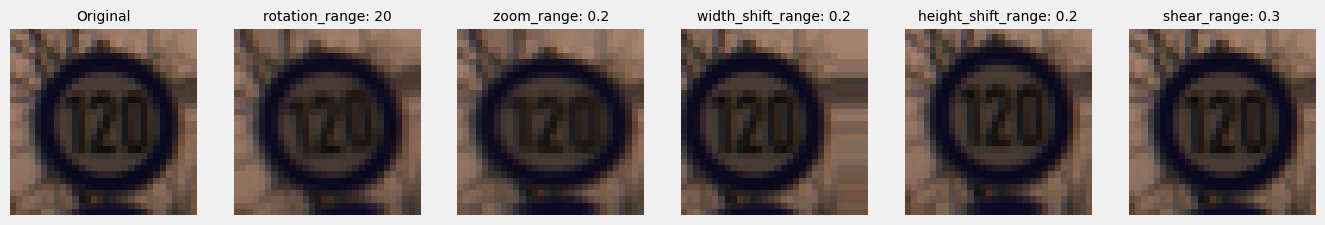

In [36]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def plot_augmentation_effects(image, augmenter, augmentation_types):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 6, 1)
    plt.imshow(image)
    plt.title("Original", fontsize=10)  # 设置标题字体大小
    plt.axis('off')

    for i, (aug_type, param) in enumerate(augmentation_types.items()):
        # 创建一个包含特定增强操作的 ImageDataGenerator
        augmenter = ImageDataGenerator(**{aug_type: param})
        augmented_img = augmenter.random_transform(image)
        
        # 显示增强后的图像
        plt.subplot(1, 6, i + 2)  # 修正位置，使得标题不重叠
        plt.imshow(augmented_img)
        plt.title(f"{aug_type}: {param}", fontsize=10)  # 设置标题字体大小
        plt.axis('off')

    plt.show()

# 随机选择三张图像进行增强
random_indices = random.sample(range(len(X_train)), 3)  # 随机选择3个索引

augmentation_types = {
    "rotation_range": 20,
    "zoom_range": 0.2,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.3
}

# 对每张随机选中的图片进行增强展示
for idx in random_indices:
    sample_image = X_train[idx]  # 获取随机选中的图像
    plot_augmentation_effects(sample_image, aug, augmentation_types)  # 进行数据增强并展示


## 数据增强 训练模型

In [17]:
from tensorflow.keras.callbacks import TensorBoard
import os

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
                        )

# 设置 TensorBoard 回调
log_dir = os.path.join("logs", "fit", "model")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# %load_ext tensorboard
# %tensorboard --logdir logs/fit

steps_per_epoch = len(X_train) // batch_size

history = model.fit(aug.flow(X_train, y_train, batch_size=batch_size), 
                    epochs=epochs, 
                    validation_data=(X_val, y_val), 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[tensorboard_callback])




Epoch 1/100
  1/107 [..............................] - ETA: 0s - loss: 5.9259 - accuracy: 0.0195WARNING:tensorflow:From C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
107/107 [==============================] - 17s 156ms/step - loss: 3.0318 - accuracy: 0.4339 - val_loss: 5.6111 - val_accuracy: 0.0556
Epoch 2/100
107/107 [==============================] - 17s 157ms/step - loss: 1.4581 - accuracy: 0.7795 - val_loss: 7.0719 - val_accuracy: 0.0555
Epoch 3/100
107/107 [==============================] - 18s 165ms/step - loss: 1.0045 - accuracy: 0.8873 - val_loss: 5.7440 - val_accuracy: 0.0655
Epoch 4/100
107/107 [==============================] - 19s 180ms/step - loss: 0.7570 - accuracy: 0.9353 - val_loss: 3.0627 - val_accuracy: 0.3704
Epoch 5/100
107/107 [==================

## 评估模型

In [18]:
history_df = pd.DataFrame(history.history)

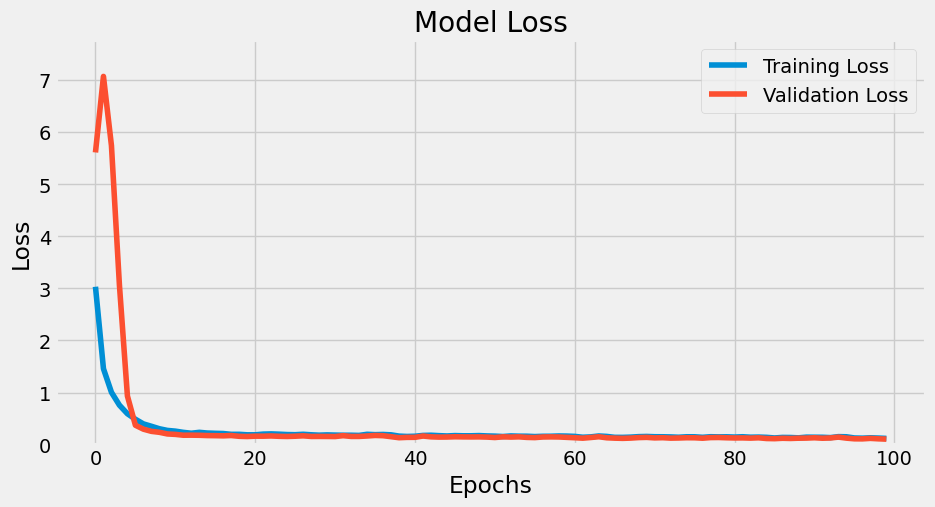

In [19]:
# 绘制 Loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, max(history_df['loss'].max(), history_df['val_loss'].max()) * 1.1)
plt.show()

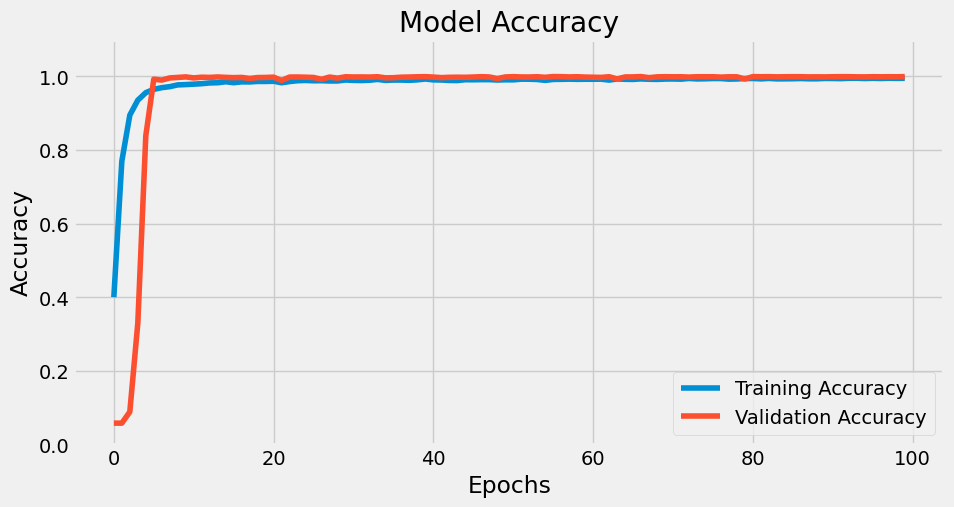

In [22]:
# 绘制 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.1)  # 确保Y轴从0到1
plt.show()

## 加载测试集并且预测

In [20]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test Data accuracy:  98.19477434679335


## 可视化混淆矩阵

In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

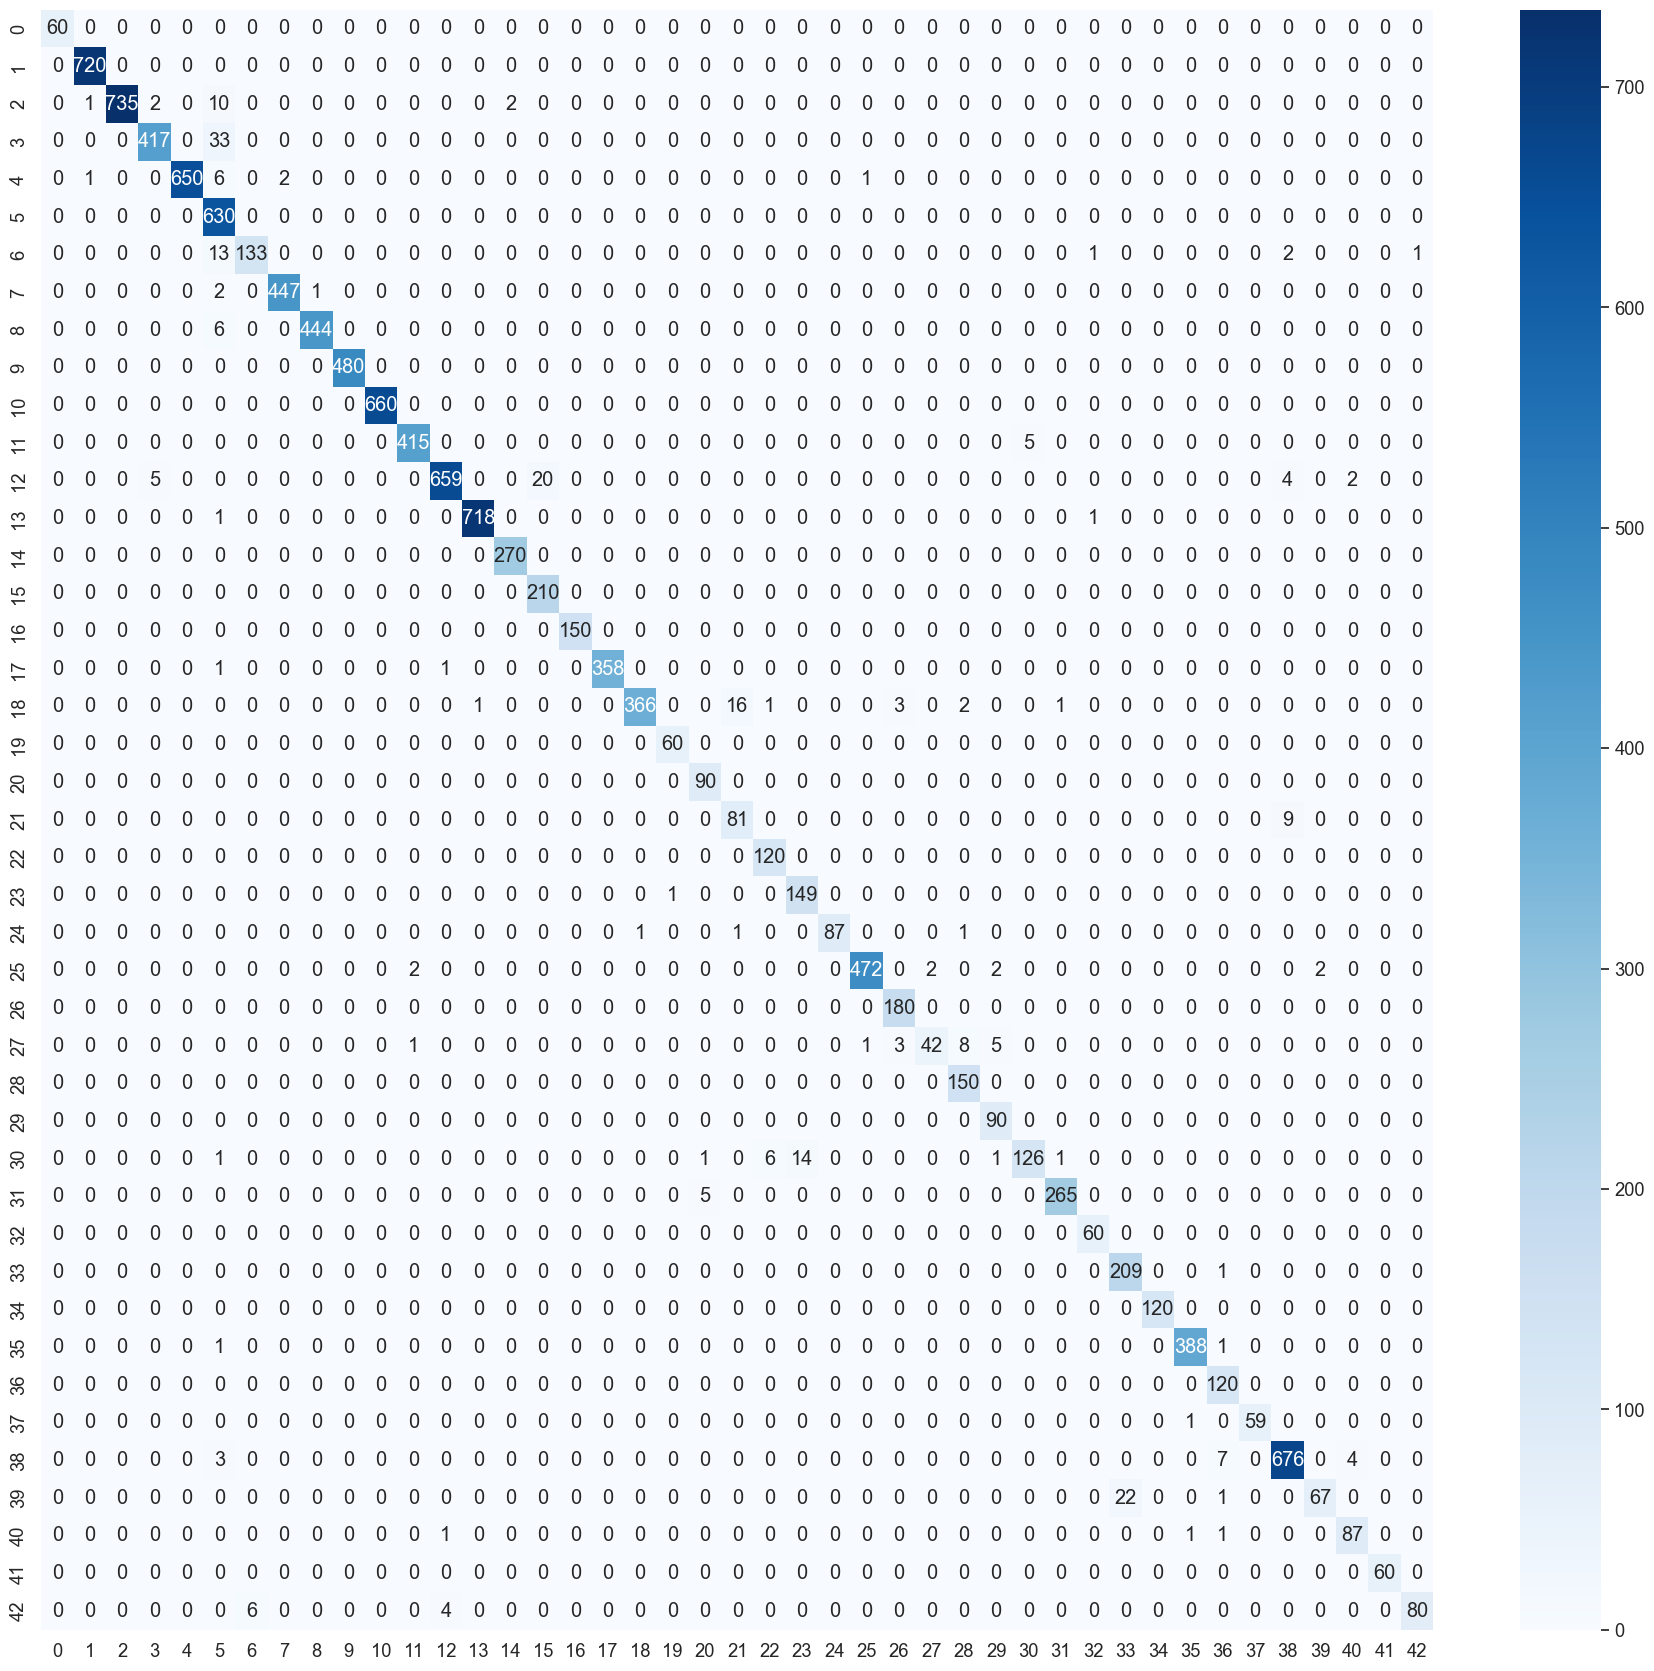

In [120]:
import seaborn as sns

# 创建带类别标签的 DataFrame
df_cm = pd.DataFrame(cf, index=classes, columns=classes)
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")  # fmt="d" 显示整数
plt.show()


## 分类报告

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      0.98      0.99       750
           3       0.99      0.93      0.96       450
           4       1.00      0.99      0.99       660
           5       0.90      1.00      0.95       630
           6       0.93      0.91      0.92       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.99      0.99       420
          12       0.99      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

## 随机测试集数据预测

Test set accuracy: 97.86%


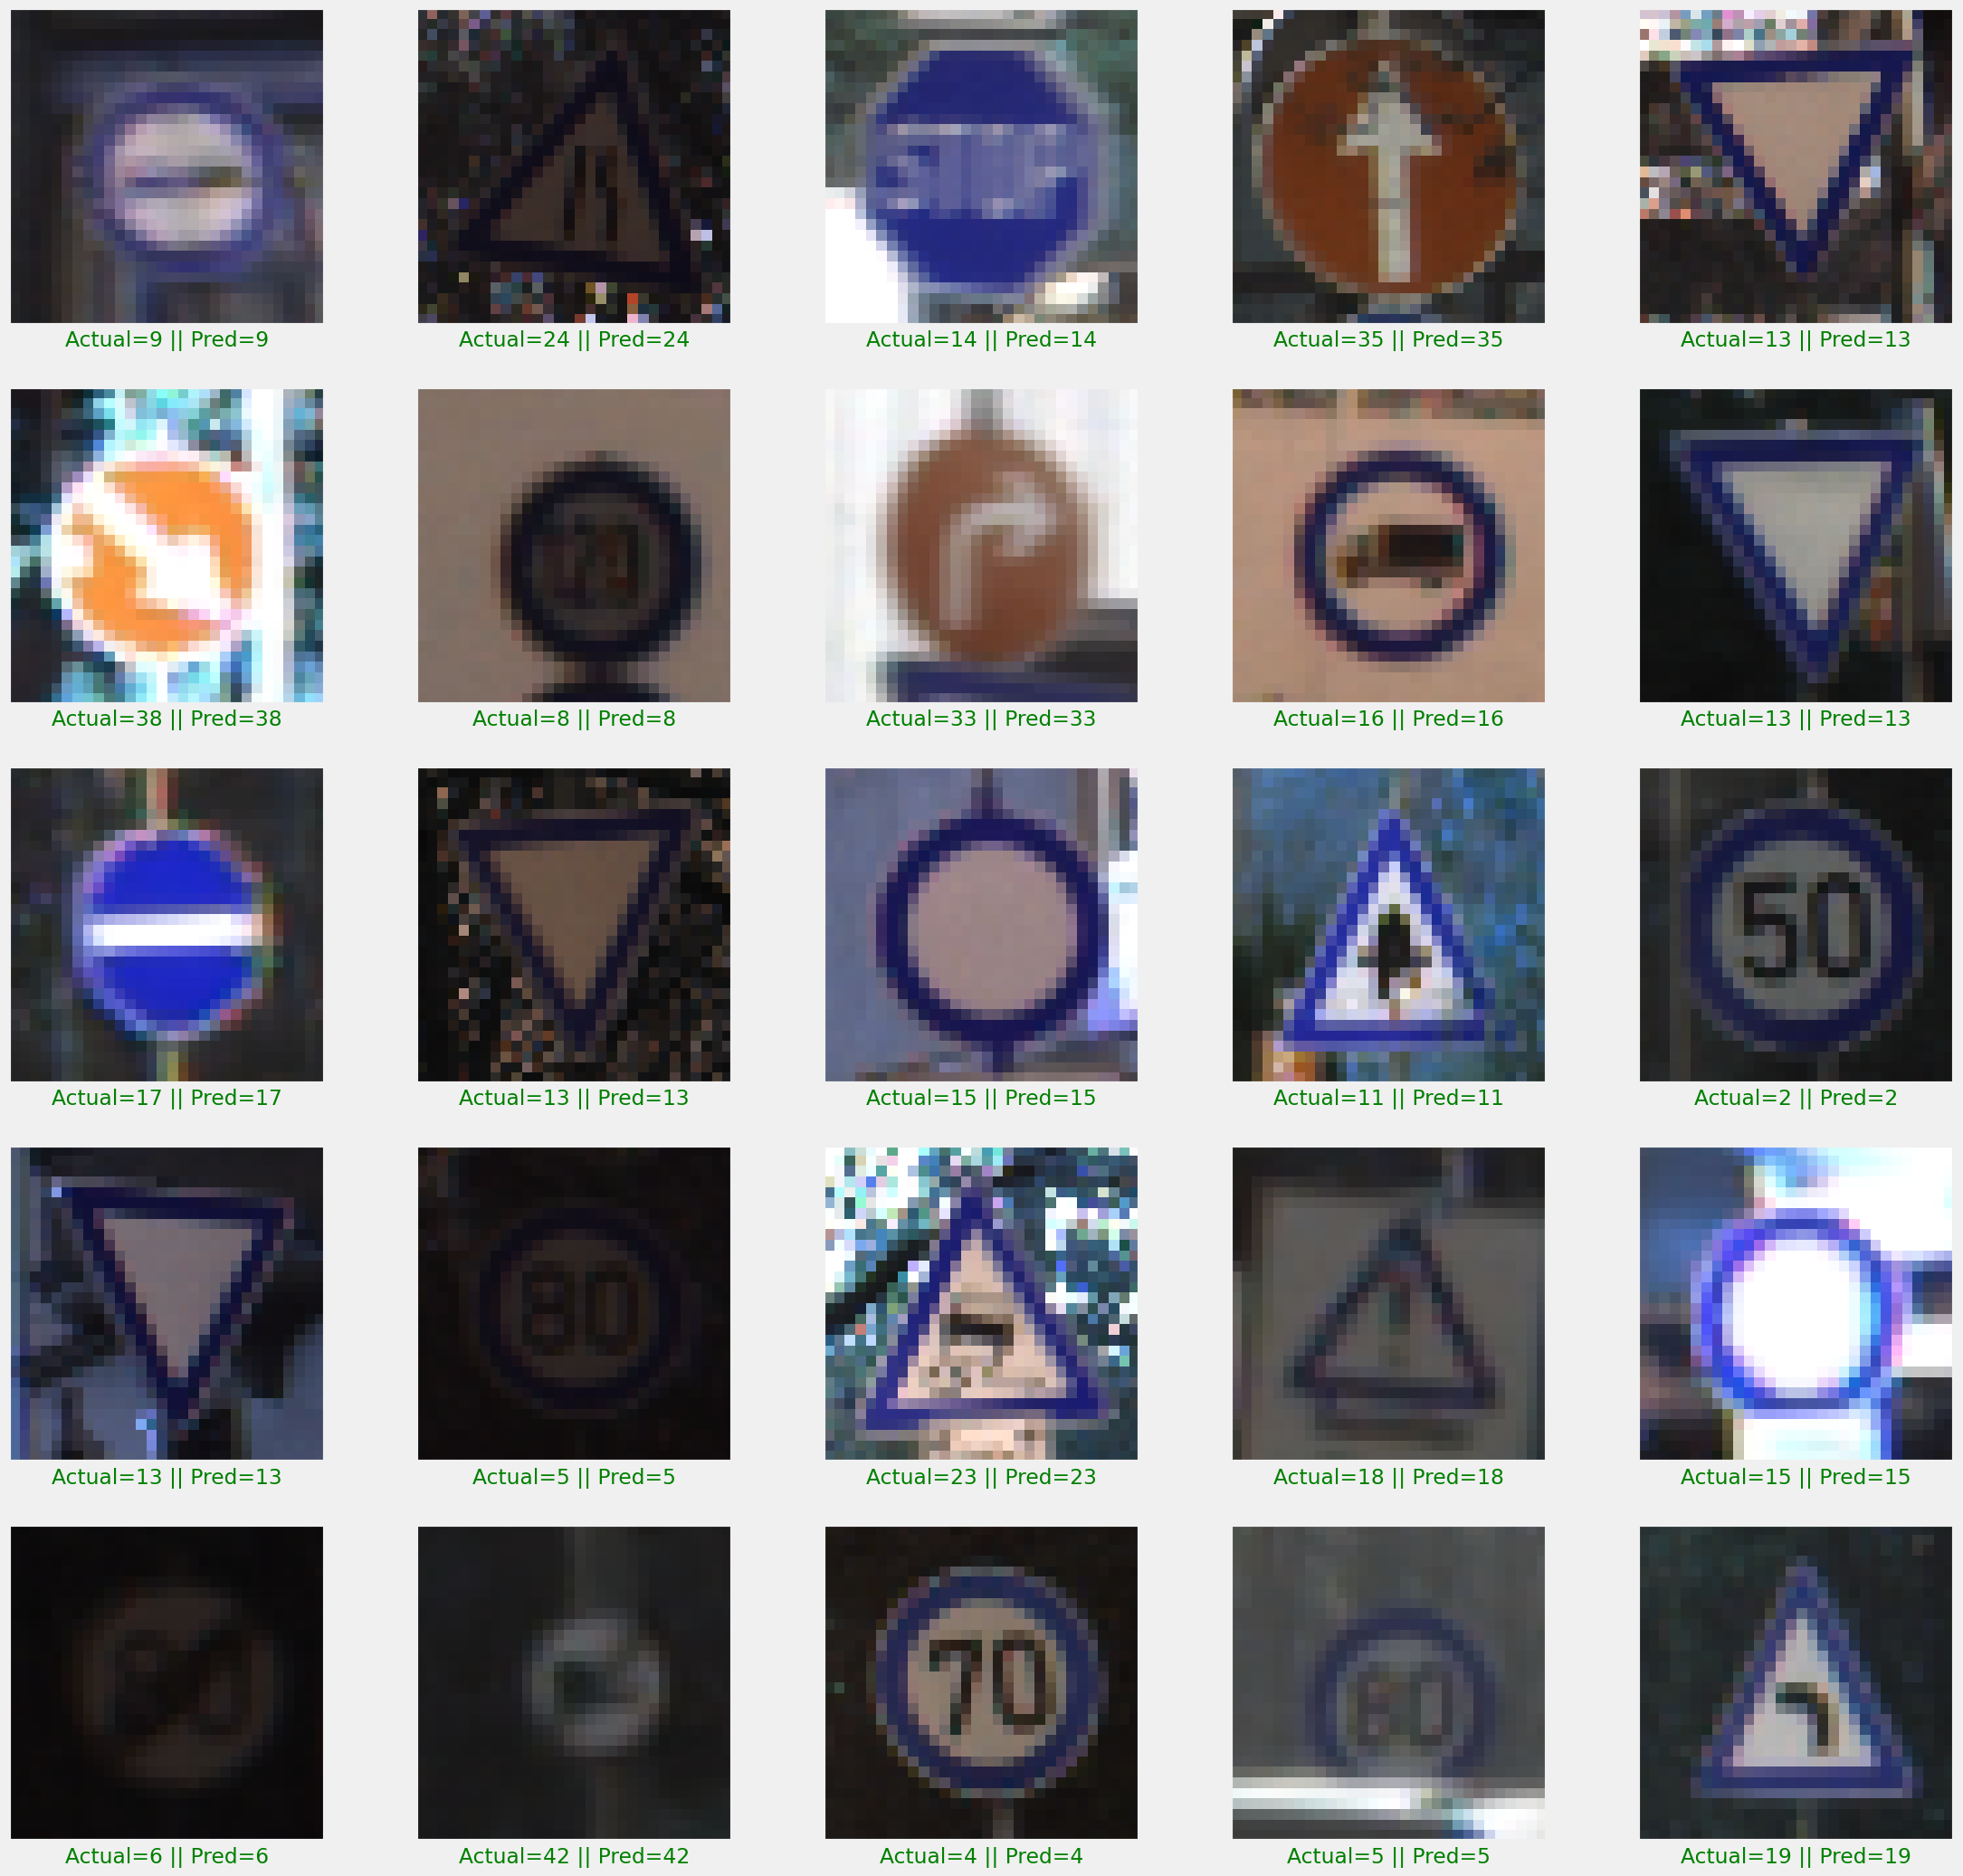

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 假设Test.csv包含 "ClassId" 和 "Path" 两列
test_data = pd.read_csv(data_dir + '/Test.csv')
labels = test_data["ClassId"].values
imgs = test_data["Path"].values

# 加载测试集图片数据
data = []
for img_path in imgs:
    image = cv2.imread(data_dir + '/' + img_path)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(image))
X_test = np.array(data) / 255.0  # 归一化

# 预测并计算测试集准确率
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
test_accuracy = accuracy_score(labels, pred)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

# 随机选择25张图片显示预测情况
random_indices = np.random.choice(len(X_test), 25, replace=False)

plt.figure(figsize=(25, 25))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[idx]
    actual = labels[idx]
    color = 'g' if prediction == actual else 'r'
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=color)
    plt.imshow(X_test[idx])
plt.show()


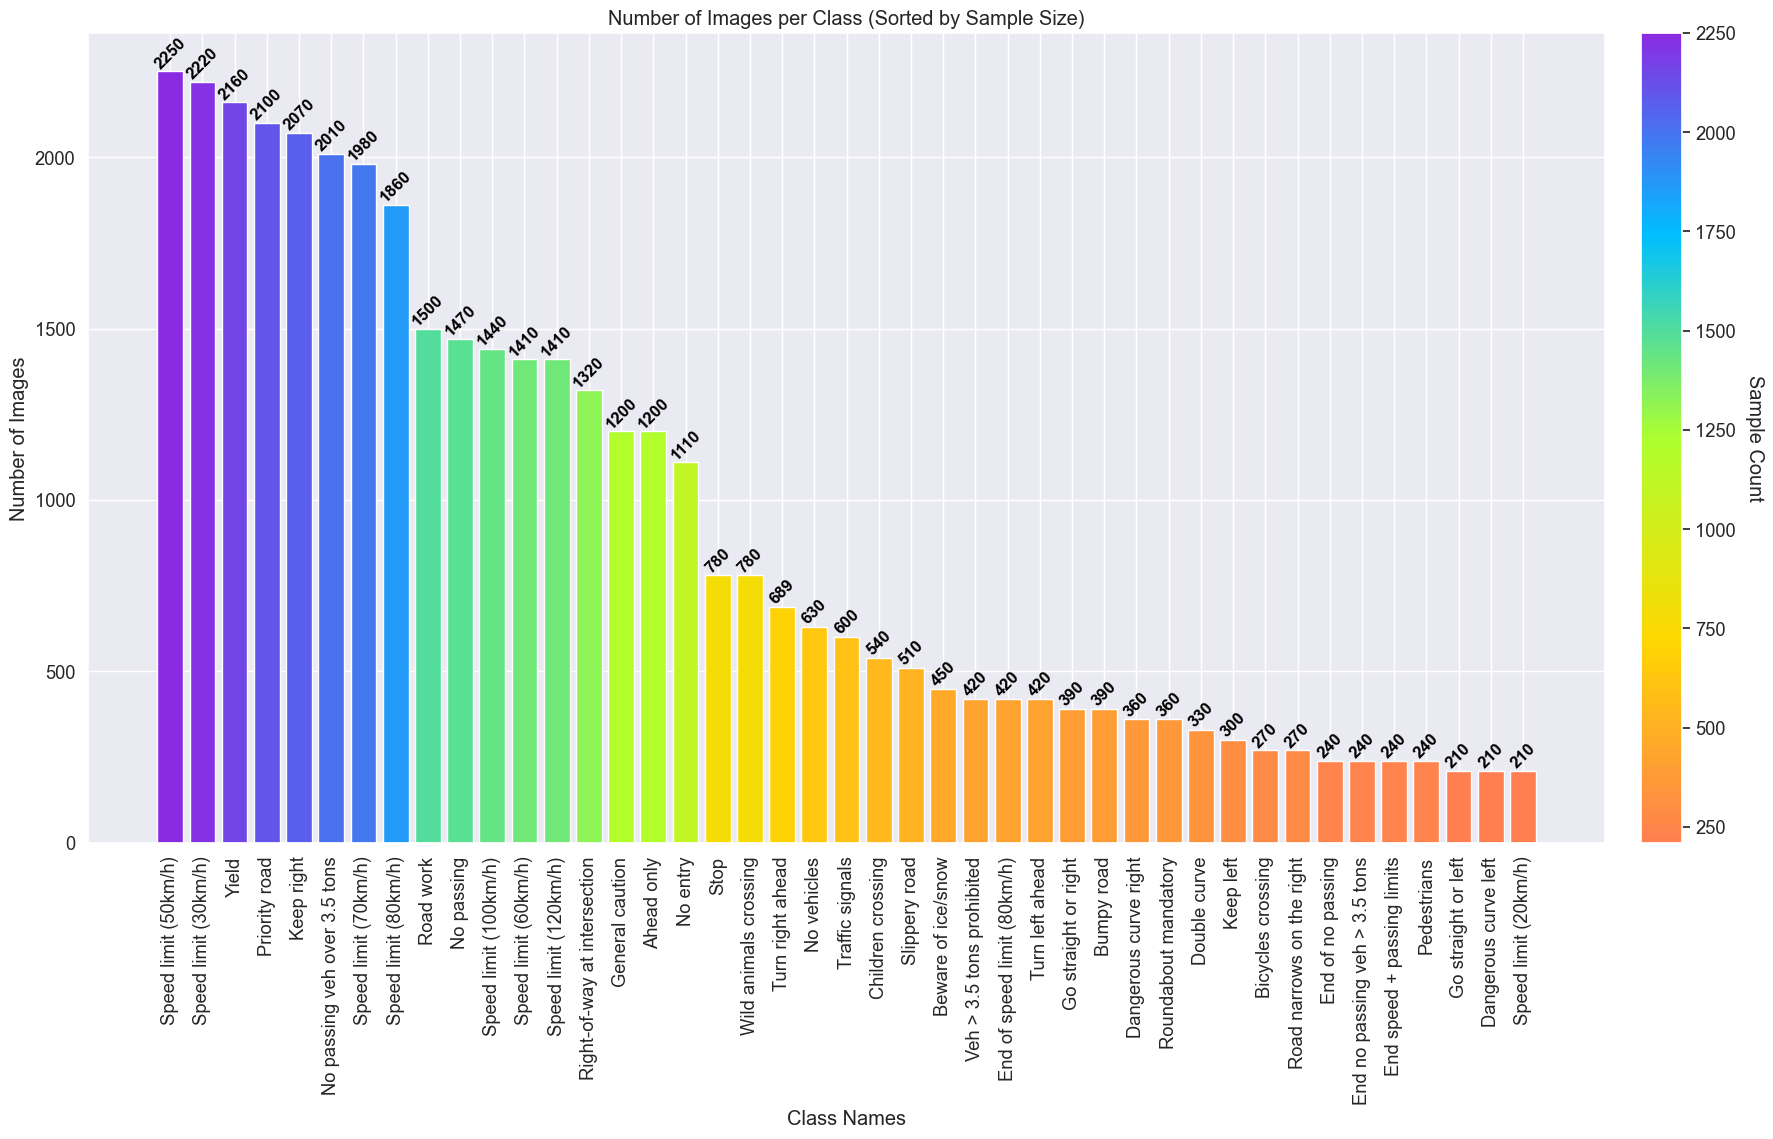

In [131]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 设置训练集路径
train_path = './datasets/Train'

# 标签
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# 统计每个类别的样本数量
train_number = []
class_names = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        train_number.append(num_images)
        class_names.append(classes.get(int(folder), f"Class {folder}"))  # 获取类别名称

# 创建DataFrame用于存储类别名称和样本数量
df_sample_counts = pd.DataFrame({
    'Class': class_names,
    'Sample Count': train_number
})

# 按样本数量对数据进行排序
df_sample_counts = df_sample_counts.sort_values(by='Sample Count', ascending=False)

# 创建渐变色调色板
cmap = LinearSegmentedColormap.from_list("grad_color", ["#FF7F50", "#FFD700", "#ADFF2F", "#00BFFF", "#8A2BE2"])

# 获取渐变色列表
norm = plt.Normalize(vmin=min(df_sample_counts['Sample Count']), vmax=max(df_sample_counts['Sample Count']))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
colors = [sm.to_rgba(x) for x in df_sample_counts['Sample Count']]

# 使用matplotlib绘制条形图
plt.figure(figsize=(21, 10))
bars = plt.bar(df_sample_counts['Class'], df_sample_counts['Sample Count'], color=colors)

# 在每个柱形的顶部添加数值标签并旋转
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold', rotation=45)

# 添加渐变色条
cbar = plt.colorbar(sm, pad=0.02)
cbar.set_label('Sample Count', rotation=270, labelpad=20)

# 设置标签和标题
plt.xticks(rotation=90)
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Sorted by Sample Size)")
plt.show()


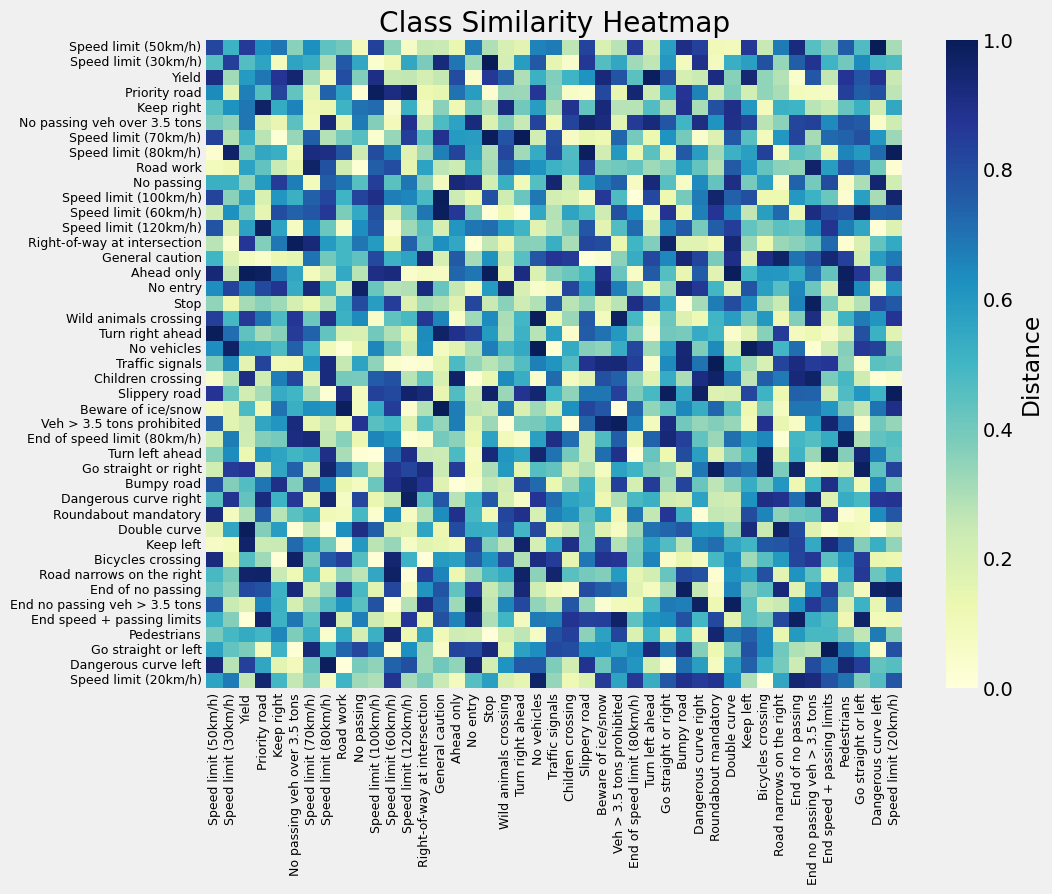

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经计算了每个类别之间的距离/相似性矩阵
# 使用随机数据来模拟此矩阵
distance_matrix = np.random.rand(len(df_sample_counts), len(df_sample_counts))

# 创建热力图，移除数字，增加颜色反差
plt.figure(figsize=(10, 8))

# 调整渐变色的对比度，可以调整 vmin 和 vmax 来放大颜色差异
sns.heatmap(distance_matrix, 
            annot=False,               # 移除数字
            cmap="YlGnBu",             # 选择渐变色
            vmin=0,                    # 设置最小值颜色
            vmax=1,                    # 设置最大值颜色
            xticklabels=df_sample_counts['Class'], 
            yticklabels=df_sample_counts['Class'],
            cbar_kws={'label': 'Distance'})  # 设置颜色条的标签

# 设置标题
plt.title('Class Similarity Heatmap')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# 显示热力图
plt.show()


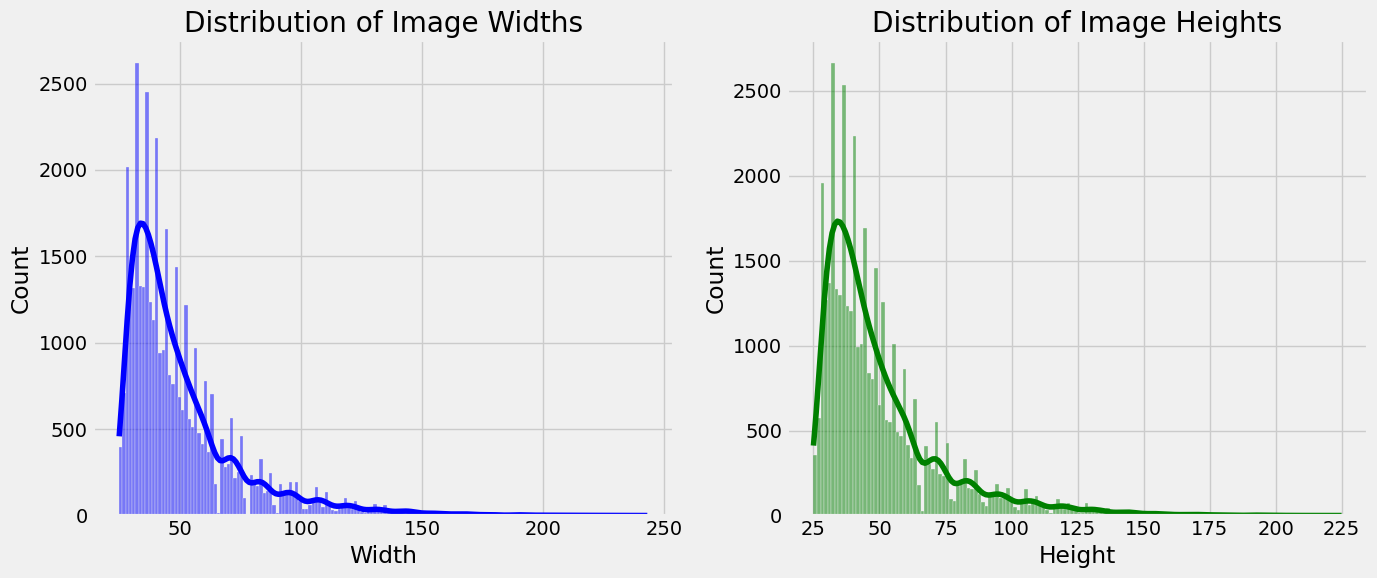

In [82]:
# 类别的图像尺寸分布

import cv2

# 统计图像的尺寸（宽度和高度）
image_widths = []
image_heights = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            image_heights.append(h)
            image_widths.append(w)

# 可视化宽度和高度的分布
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(image_widths, kde=True, color='blue')
plt.title("Distribution of Image Widths")
plt.xlabel("Width")

plt.subplot(1, 2, 2)
sns.histplot(image_heights, kde=True, color='green')
plt.title("Distribution of Image Heights")
plt.xlabel("Height")

plt.tight_layout()
plt.show()


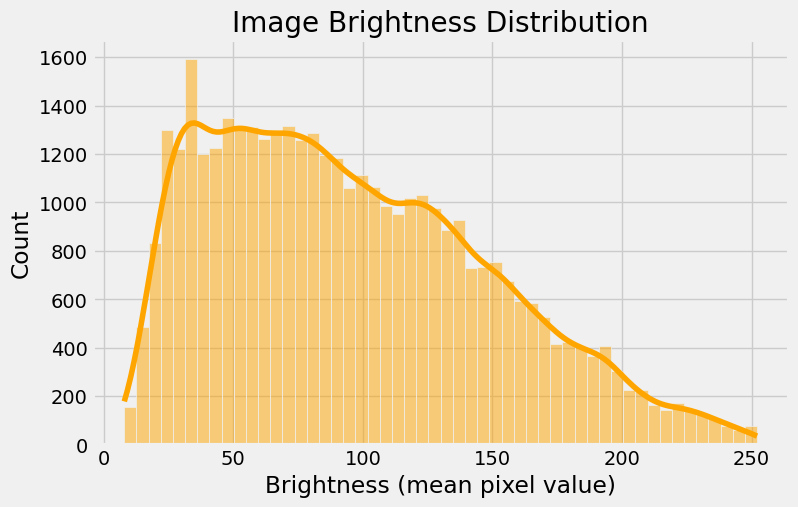

In [83]:
# 计算图像亮度的平均值 图像亮度的分布
brightness_values = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            brightness = hsv[..., 2].mean()  # 取V通道作为亮度
            brightness_values.append(brightness)

# 绘制亮度分布
plt.figure(figsize=(8, 5))
sns.histplot(brightness_values, kde=True, color='orange')
plt.title("Image Brightness Distribution")
plt.xlabel("Brightness (mean pixel value)")
plt.show()


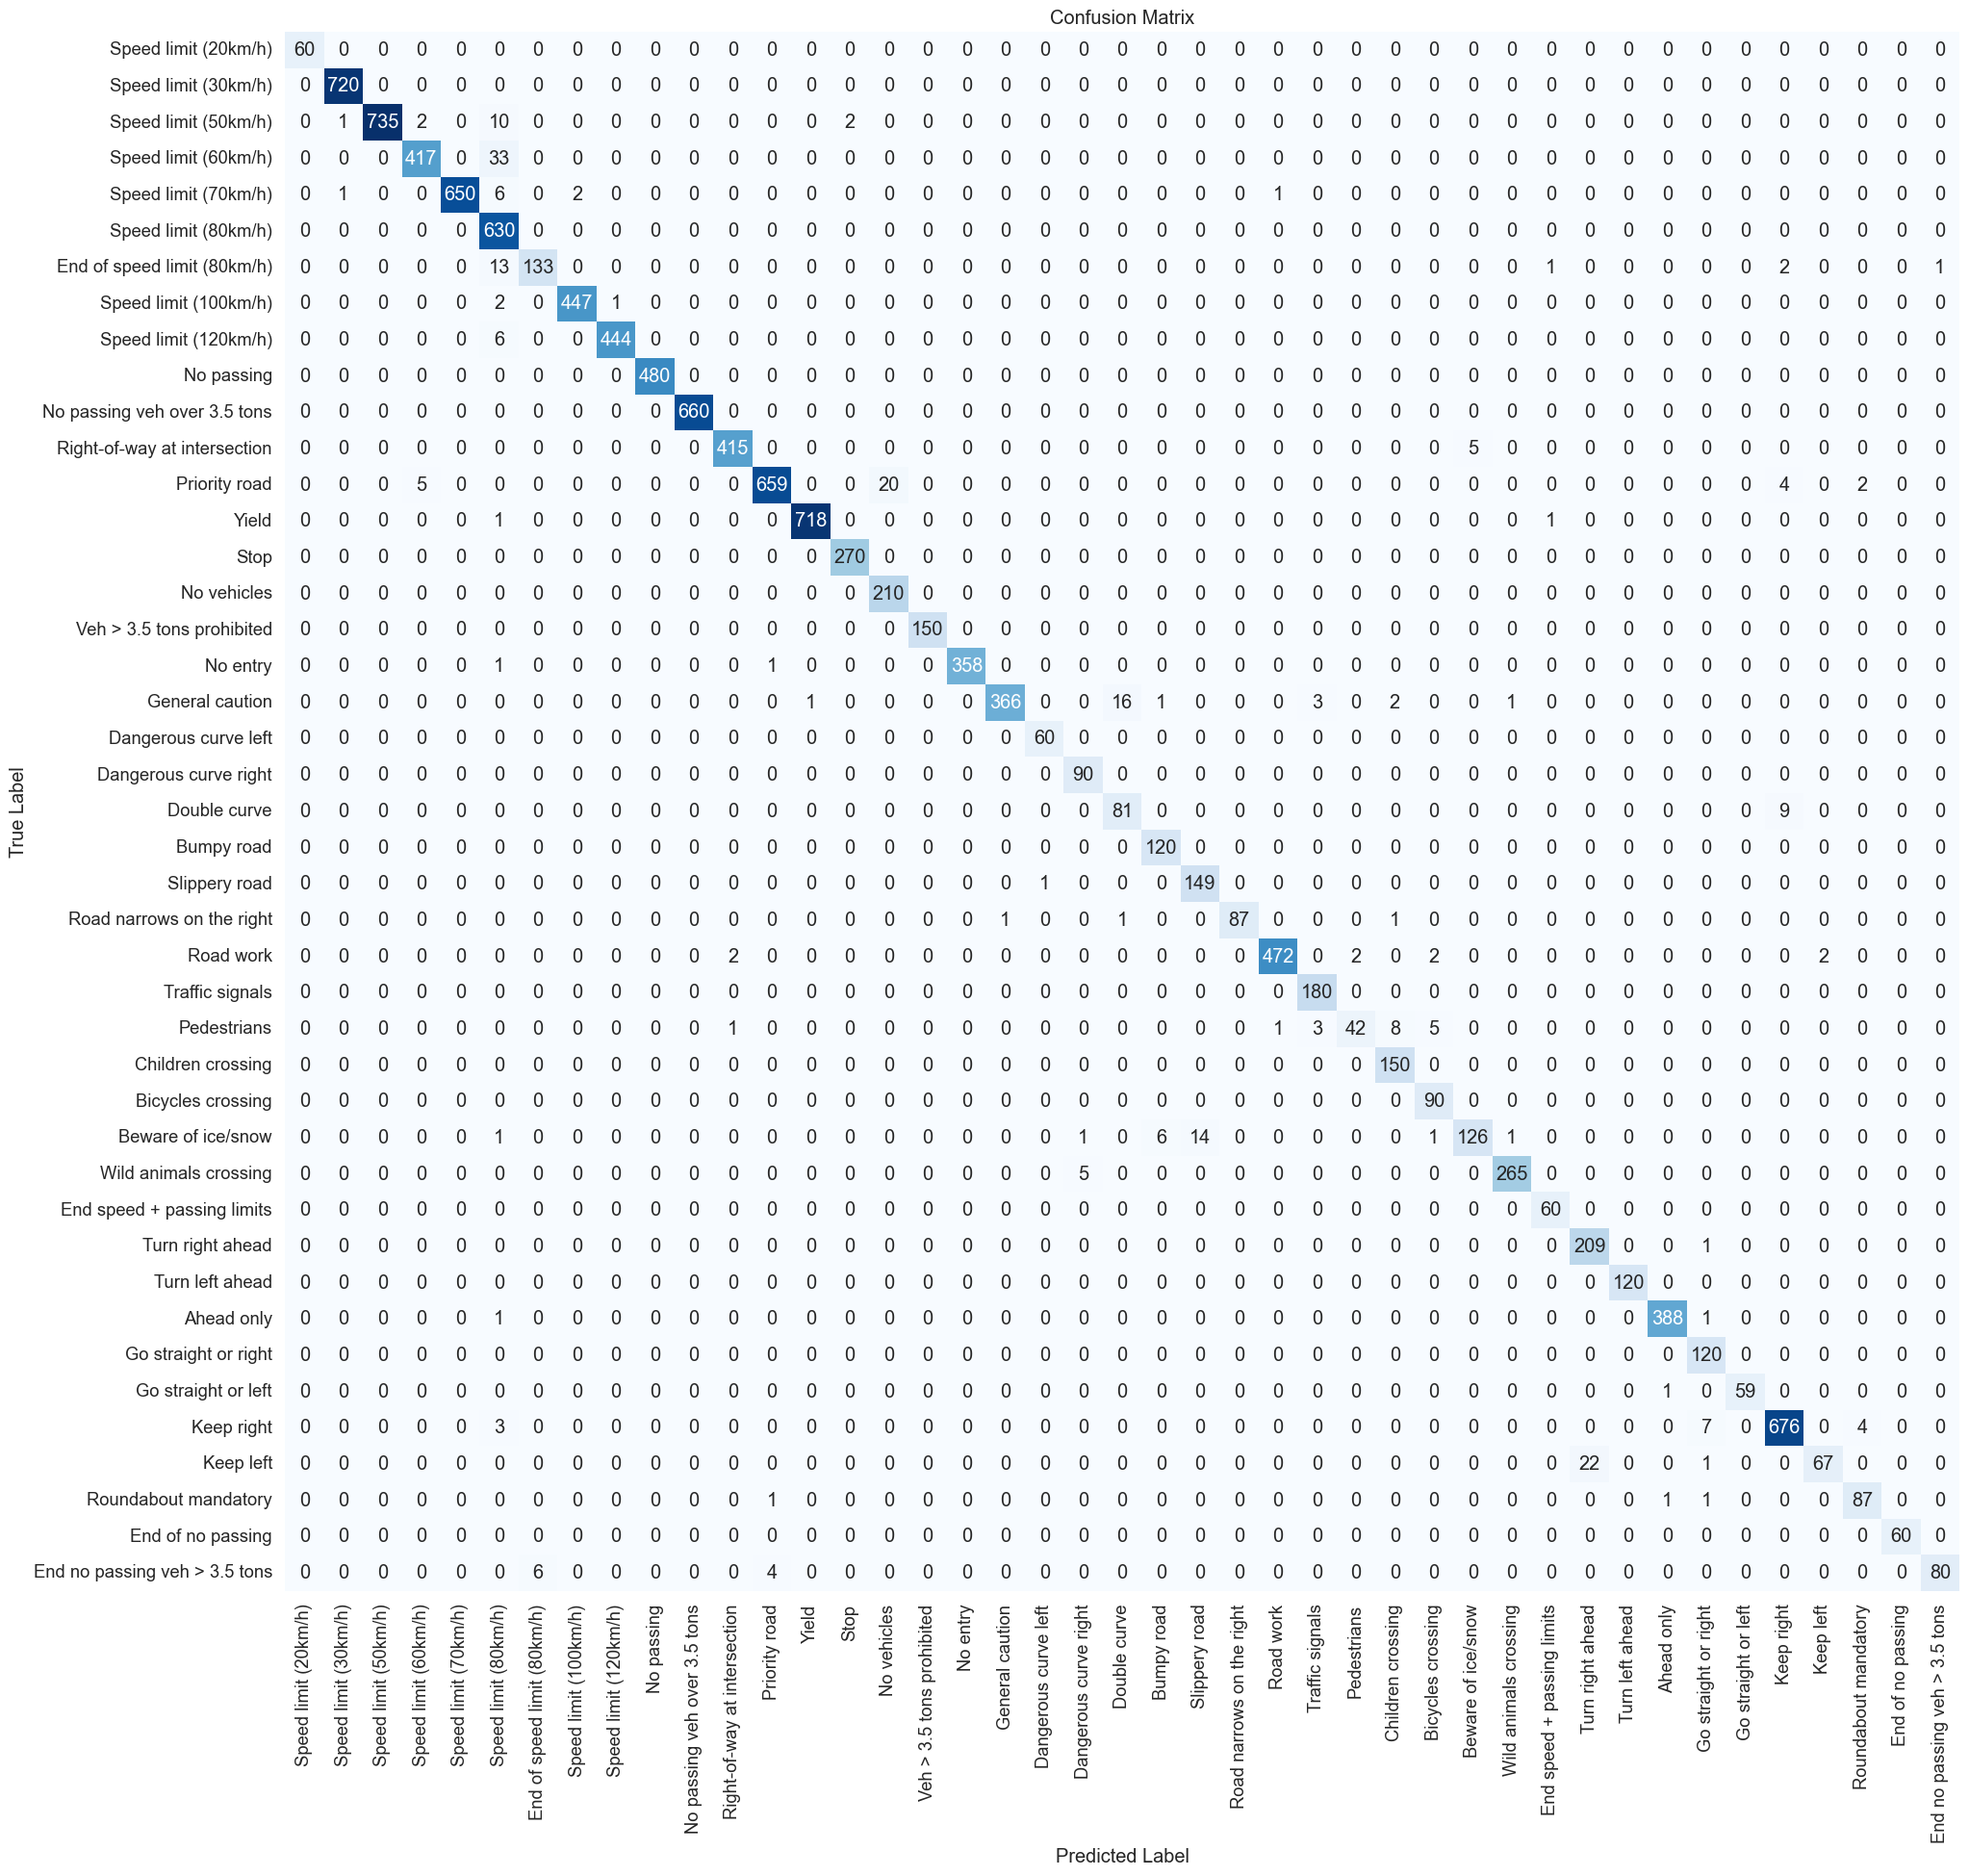

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 生成混淆矩阵
cf = confusion_matrix(labels, pred)

# 创建DataFrame用于热图显示
df_cm = pd.DataFrame(cf, index = [classes[i] for i in range(NUM_CATEGORIES)], 
                     columns = [classes[i] for i in range(NUM_CATEGORIES)])

# 绘制混淆矩阵热图
plt.figure(figsize = (20, 20))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


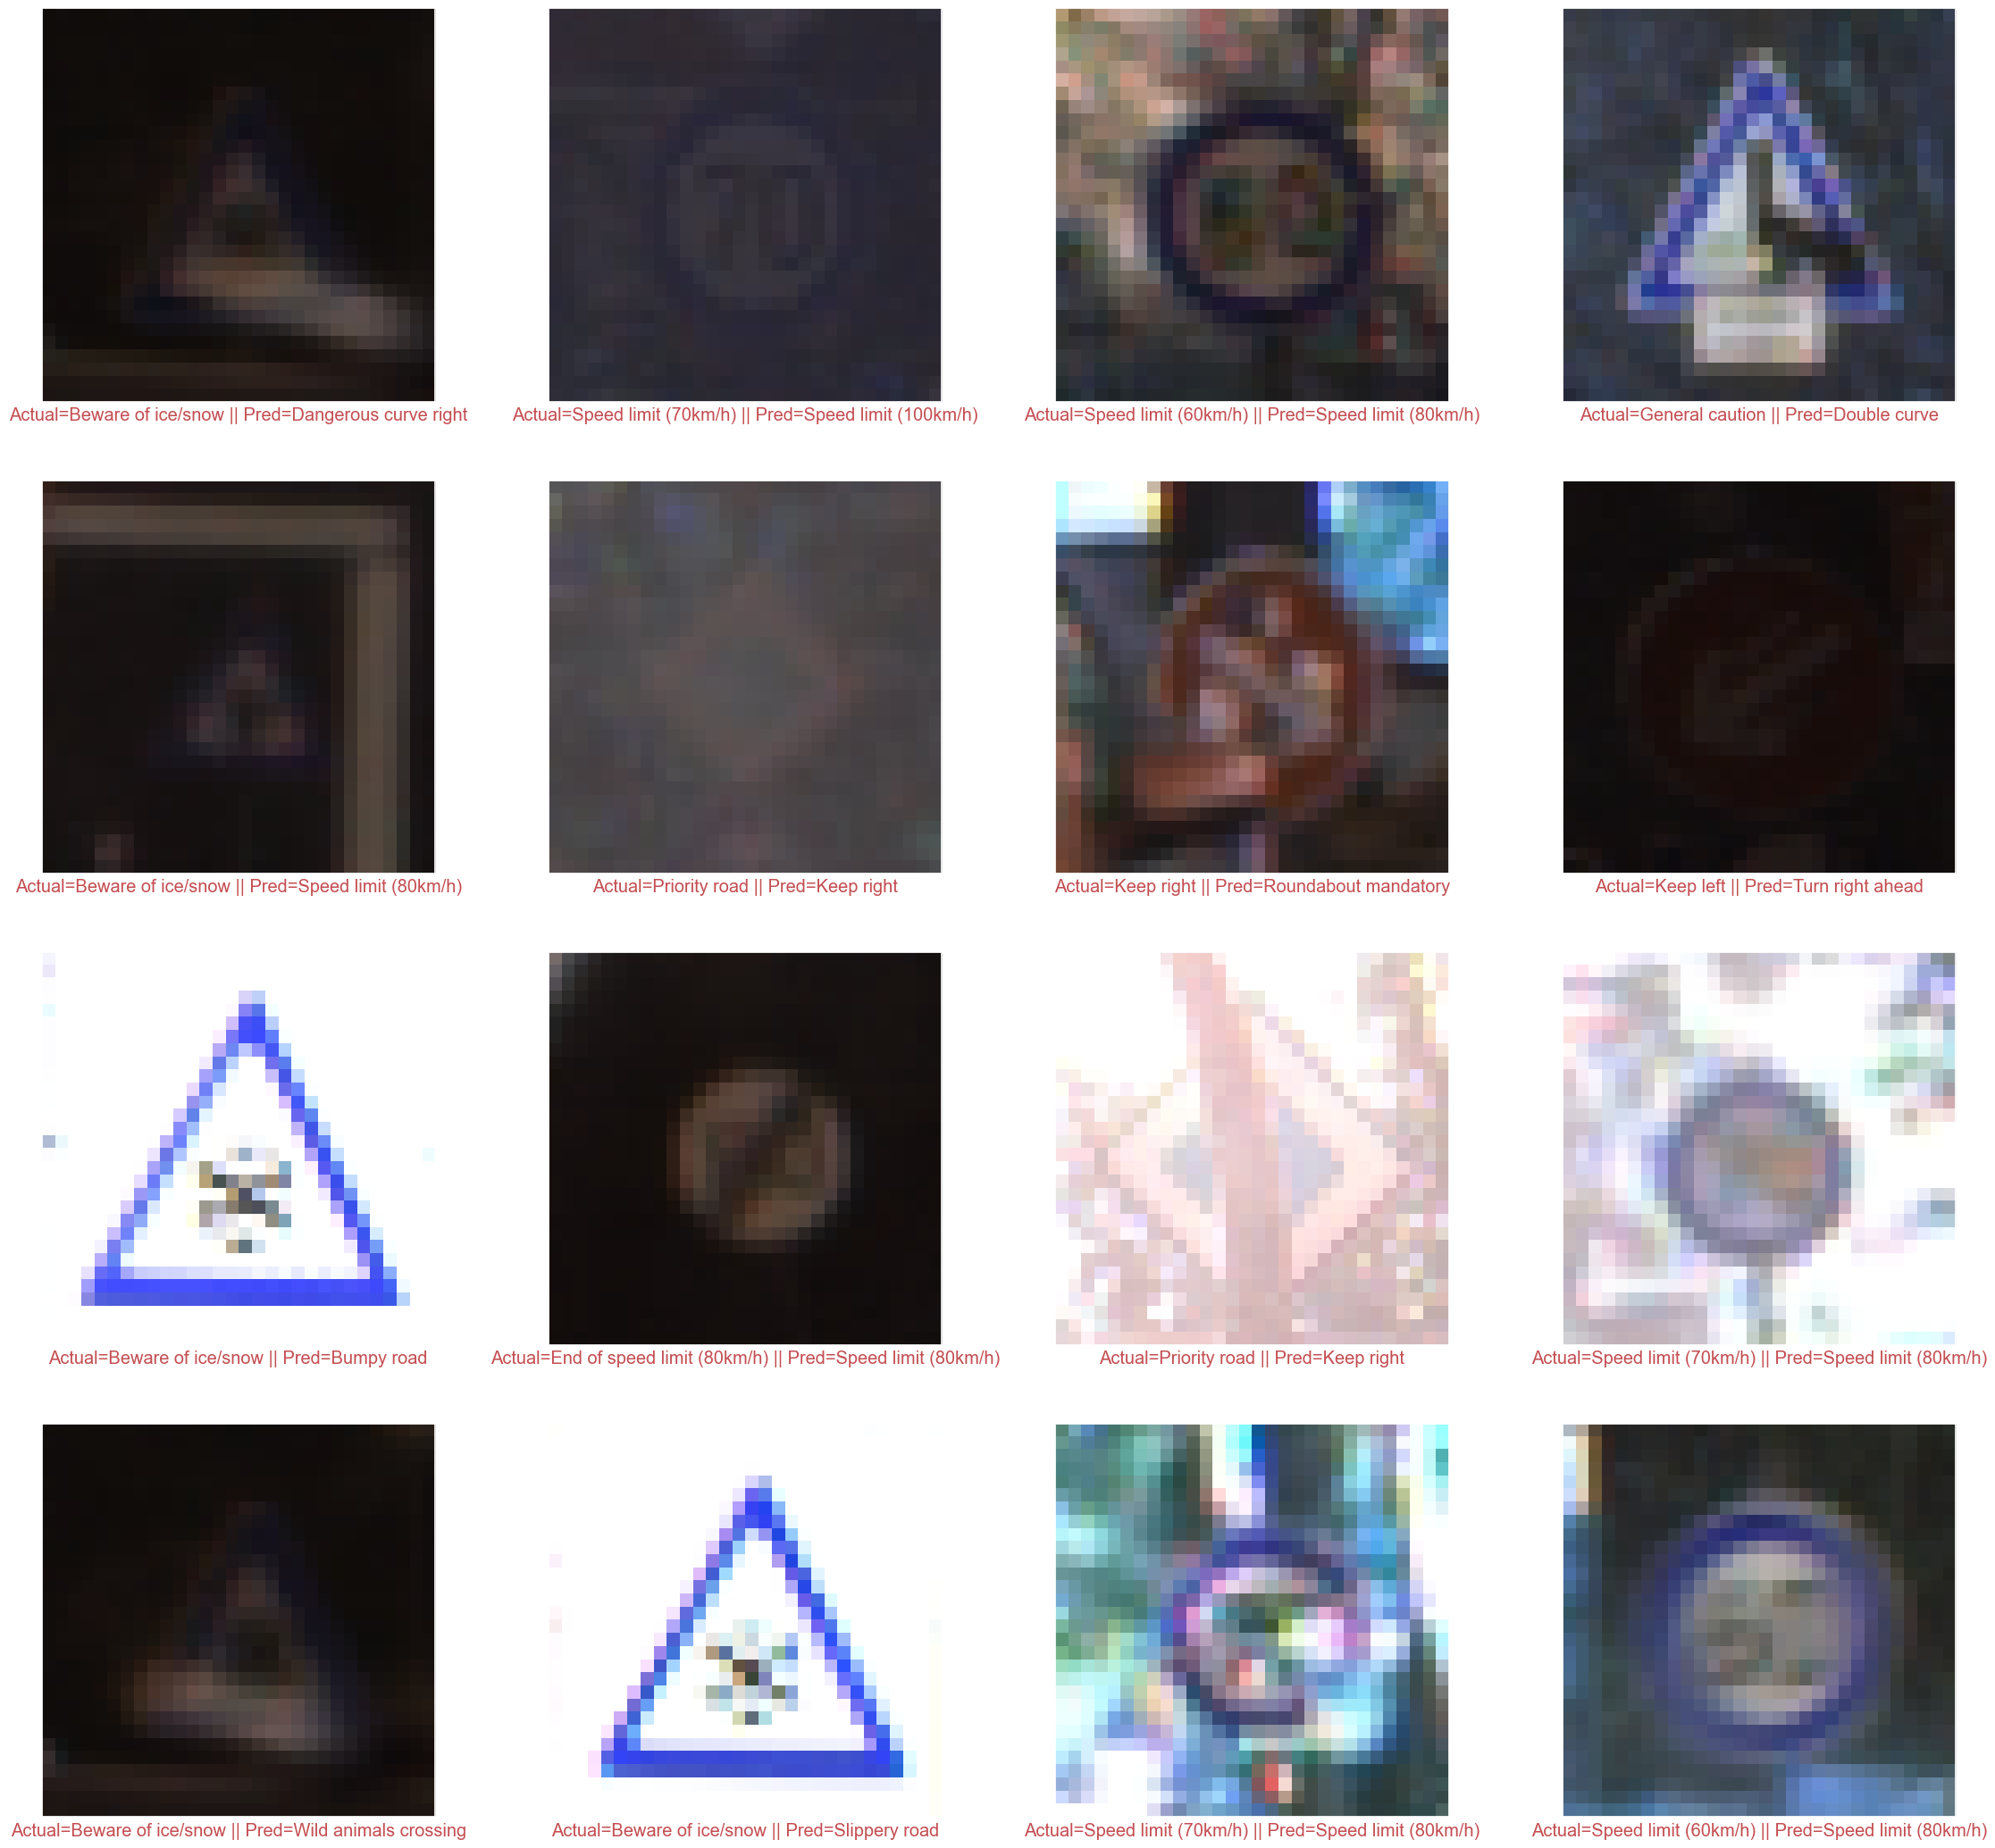

In [113]:
plt.figure(figsize = (25, 25))

# 找到错误的预测
incorrect_indices = np.where(pred != labels)[0]

start_index = 0
for i in range(16):
    if i < len(incorrect_indices):  # 如果还有错误的预测
        idx = incorrect_indices[i]
        plt.subplot(4, 4, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        prediction = pred[idx]
        actual = labels[idx]
        col = 'r'  # 默认红色，表示错误预测
        if prediction == actual:
            col = 'g'  # 绿色，表示正确预测

        # 标注预测和真实类别
        plt.xlabel('Actual={} || Pred={}'.format(classes[actual], classes[prediction]), color = col)
        plt.imshow(X_test[idx])

plt.show()


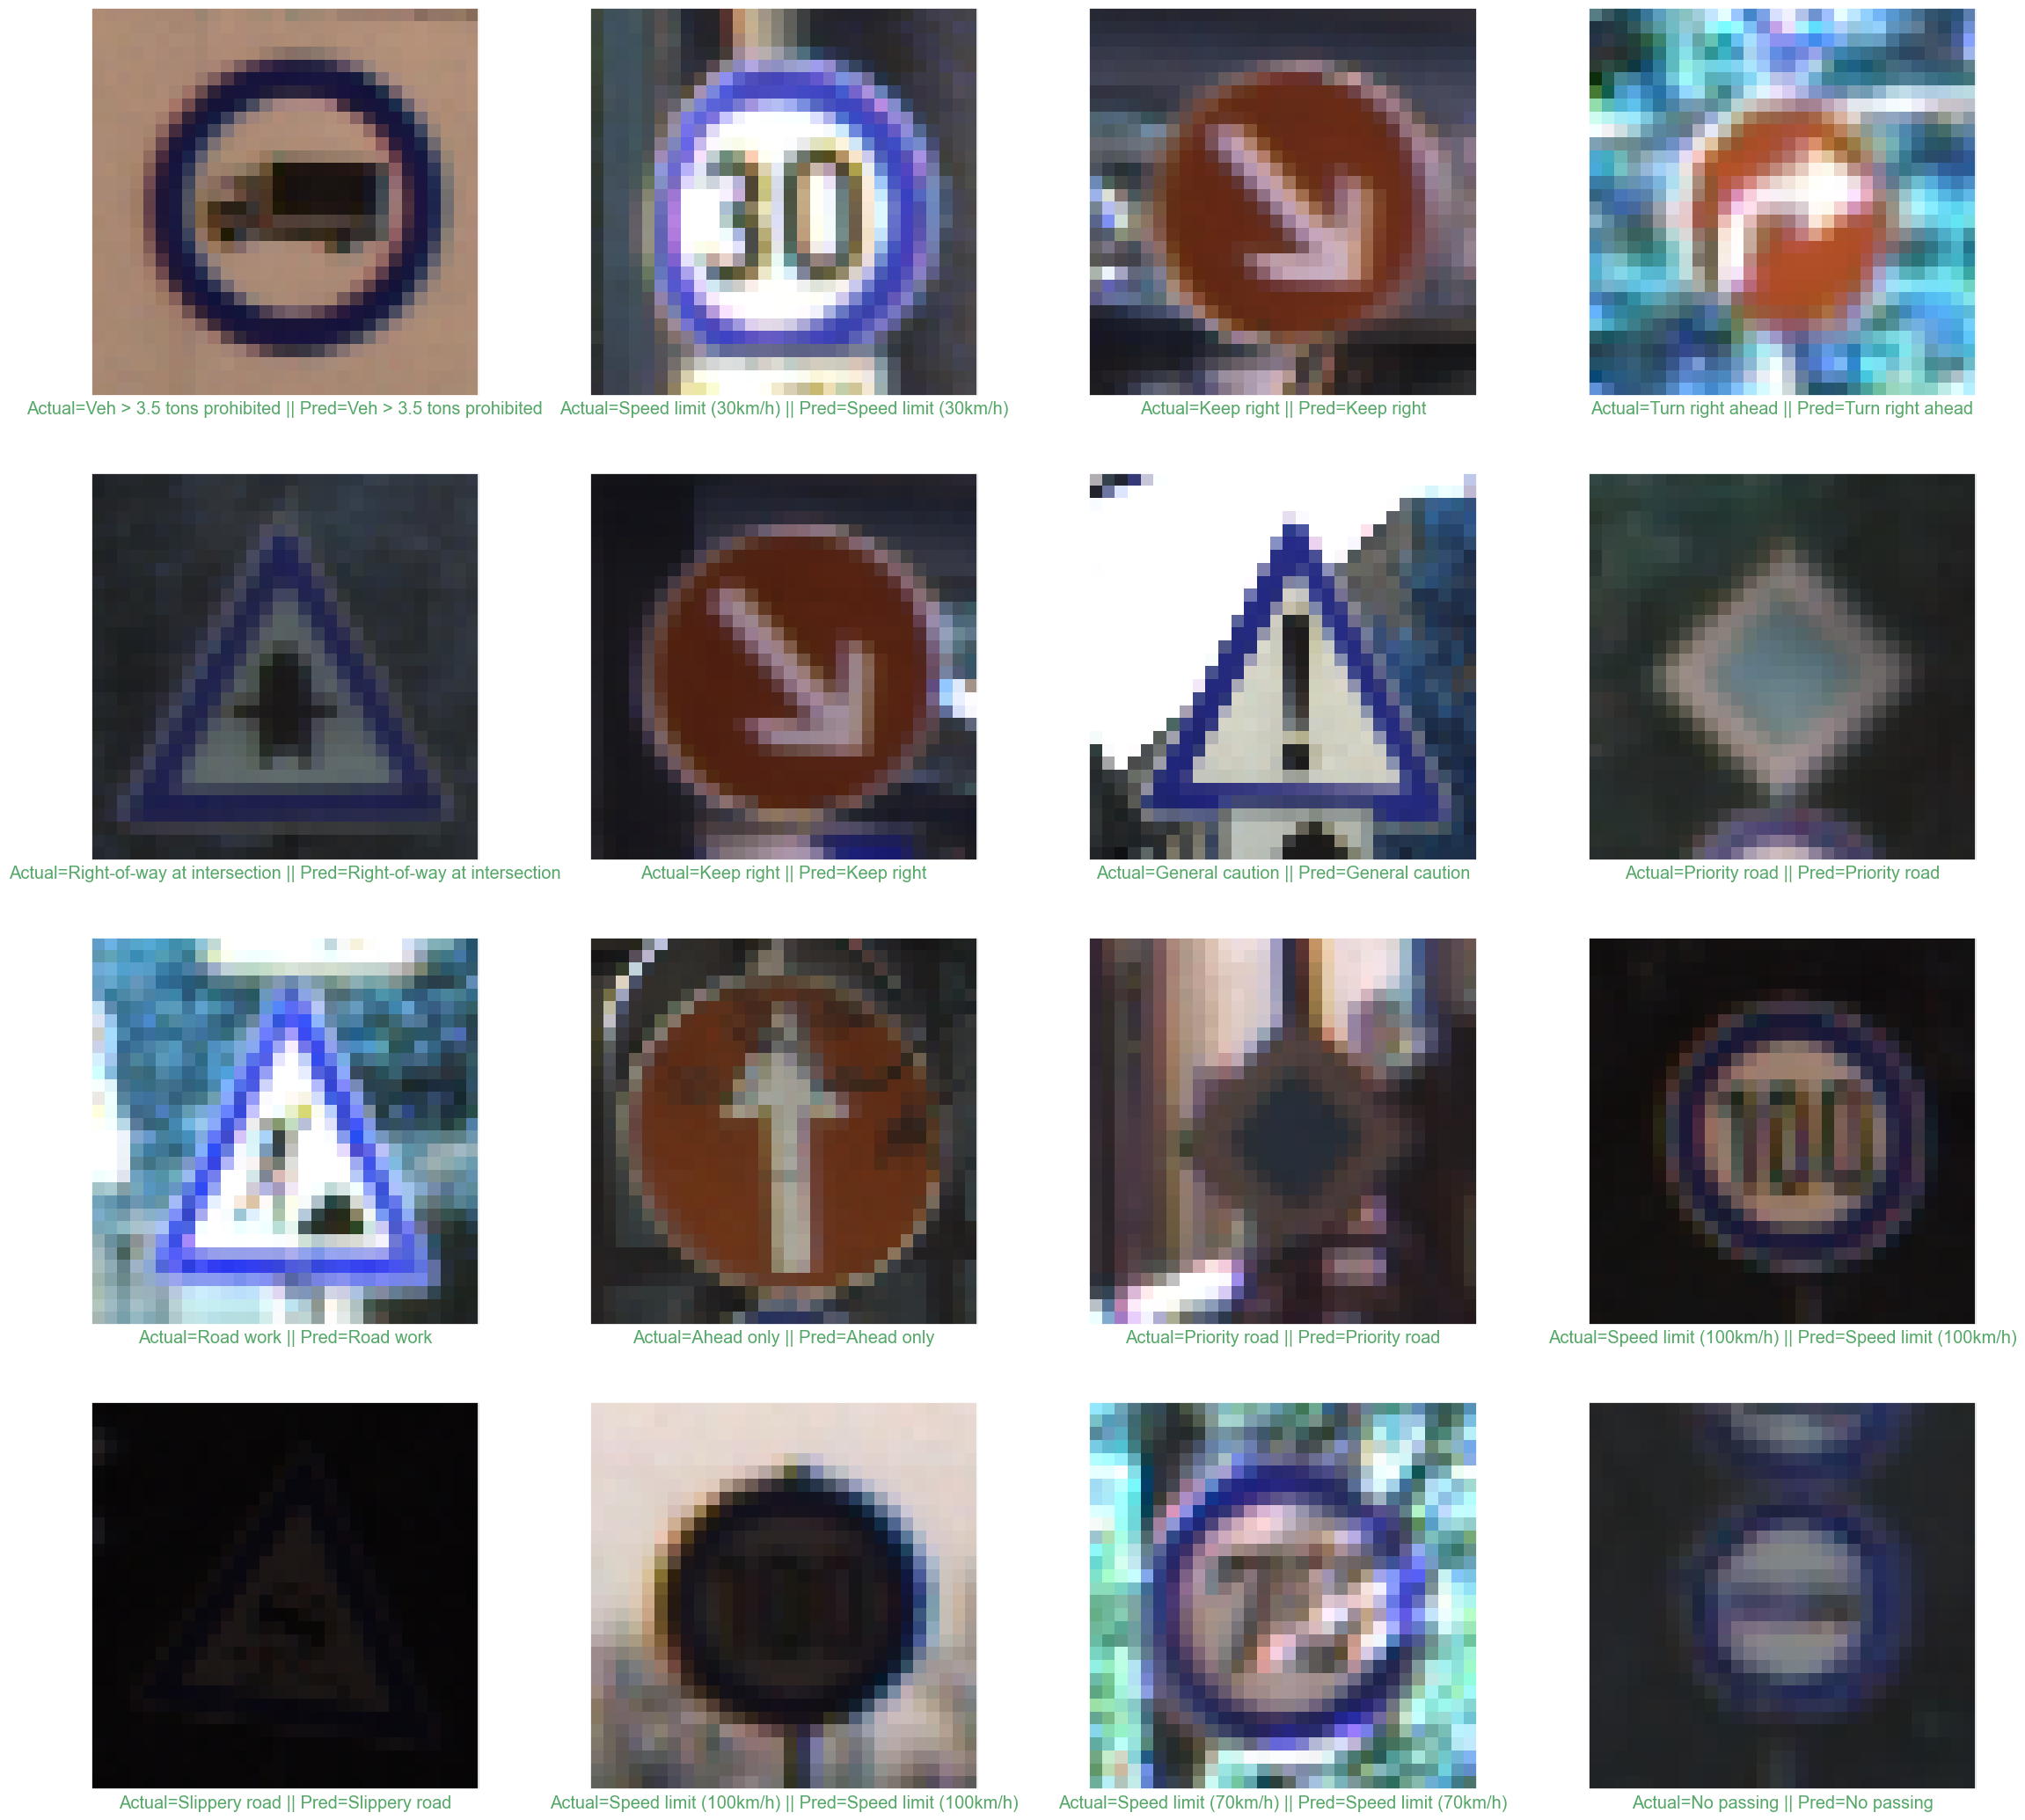

In [114]:
plt.figure(figsize = (25, 25))

# 找到正确的预测
correct_indices = np.where(pred == labels)[0]

start_index = 0
for i in range(16):
    if i < len(correct_indices):  # 如果还有正确的预测
        idx = correct_indices[i]
        plt.subplot(4, 4, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        prediction = pred[idx]
        actual = labels[idx]
        col = 'g'  # 绿色，表示正确预测

        # 标注预测和真实类别
        plt.xlabel('Actual={} || Pred={}'.format(classes[actual], classes[prediction]), color = col)
        plt.imshow(X_test[idx])

plt.show()


In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

# 提取模型的倒数第二层特征作为中间层输出
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# 提取训练集的特征
train_features = feature_extractor.predict(X_train)

# 将特征展平为一维（如果是多维的）
train_features_flattened = train_features.reshape(train_features.shape[0], -1)


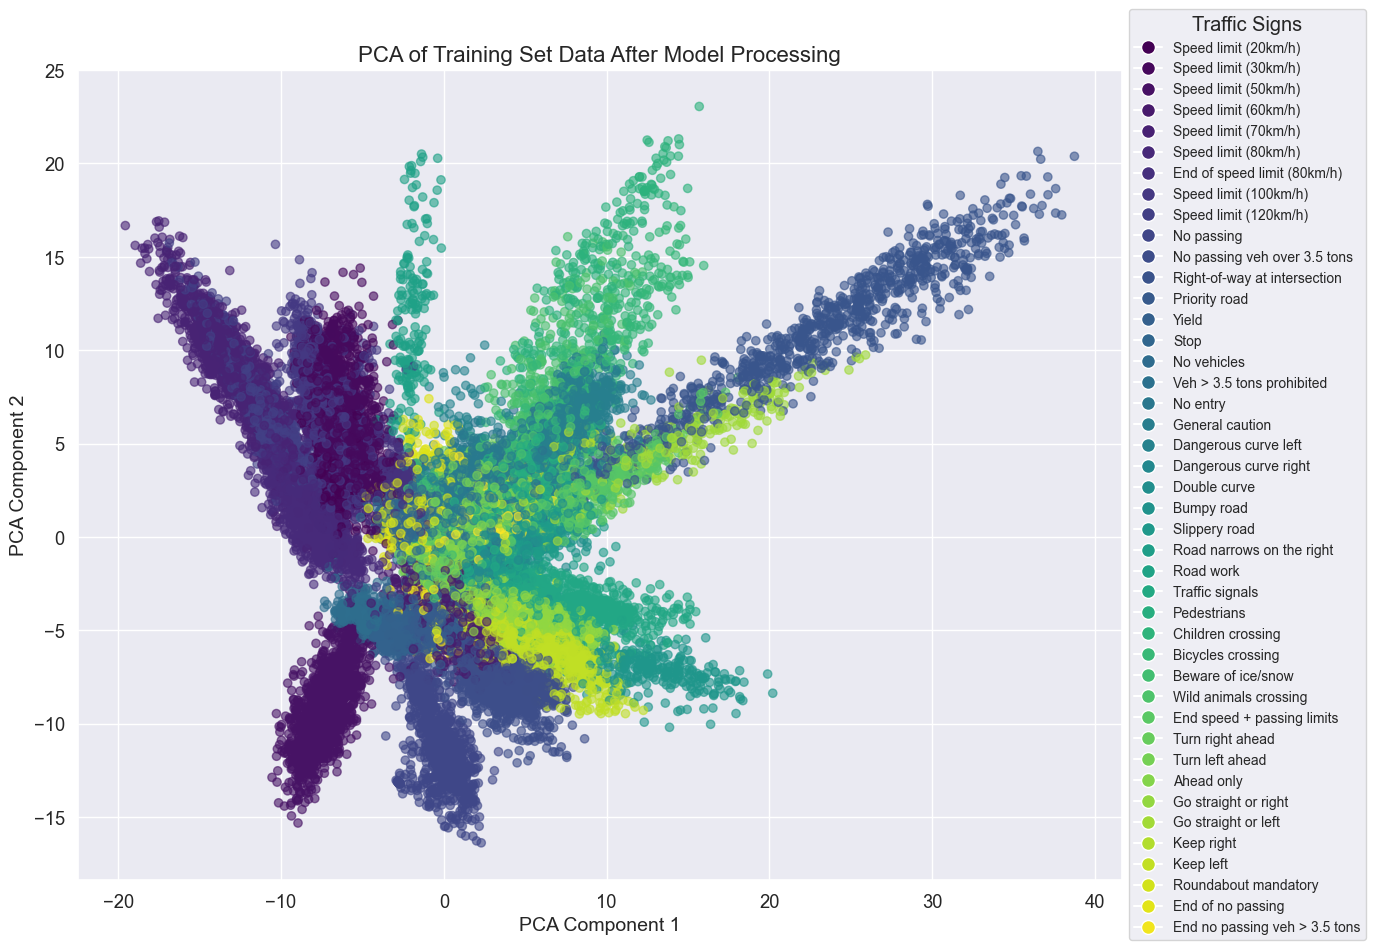

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# 提取模型的倒数第二层特征作为中间层输出
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# 提取训练集的特征
train_features = feature_extractor.predict(X_train)

# 将特征展平为一维（如果是多维的）
train_features_flattened = train_features.reshape(train_features.shape[0], -1)

# 使用PCA将特征降到二维
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(train_features_flattened)

# 绘制PCA降维后的结果
plt.figure(figsize=(12, 10))

# 创建散点图，点的颜色根据类别来指定
scatter = plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c=y_train.argmax(axis=1), cmap='viridis', alpha=0.6)

# 创建一个图例
handles, labels = [], []
for i in range(len(classes)):
    # 创建每个类别的图例条目
    handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(classes)), markersize=10, label=classes[i])
    handles.append(handle)
    labels.append(classes[i])

# 将图例添加到右侧
plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Traffic Signs', fontsize=10)

# 添加标题和标签
plt.title('PCA of Training Set Data After Model Processing', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)

# 显示图像
plt.show()


C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


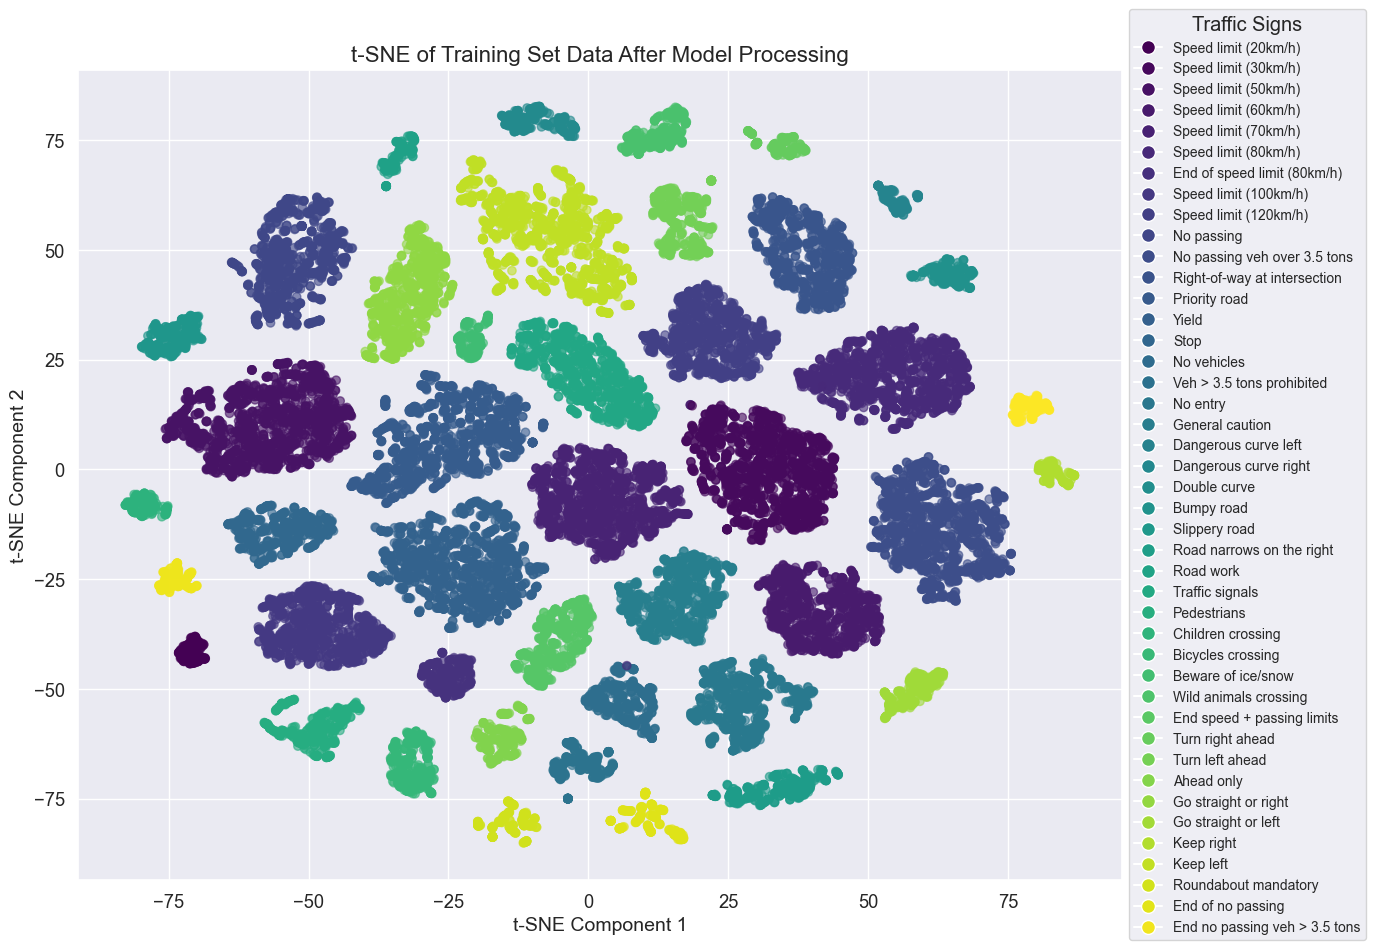

In [127]:
# 提取模型的倒数第二层特征作为中间层输出
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# 提取训练集的特征
train_features = feature_extractor.predict(X_train)

# 将特征展平为一维（如果是多维的）
train_features_flattened = train_features.reshape(train_features.shape[0], -1)

# 使用t-SNE将特征降到二维
tsne = TSNE(n_components=2, random_state=0)
reduced_features_tsne = tsne.fit_transform(train_features_flattened)

# 绘制t-SNE降维后的结果
plt.figure(figsize=(12, 10))

# 创建散点图，点的颜色根据类别来指定
scatter = plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=y_train.argmax(axis=1), cmap='viridis', alpha=0.6)

# 创建一个图例
handles, labels = [], []
for i in range(len(classes)):
    # 创建每个类别的图例条目
    handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(classes)), markersize=10, label=classes[i])
    handles.append(handle)
    labels.append(classes[i])

# 将图例添加到右侧
plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Traffic Signs', fontsize=10)

# 添加标题和标签
plt.title('t-SNE of Training Set Data After Model Processing', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# 显示图像
plt.show()


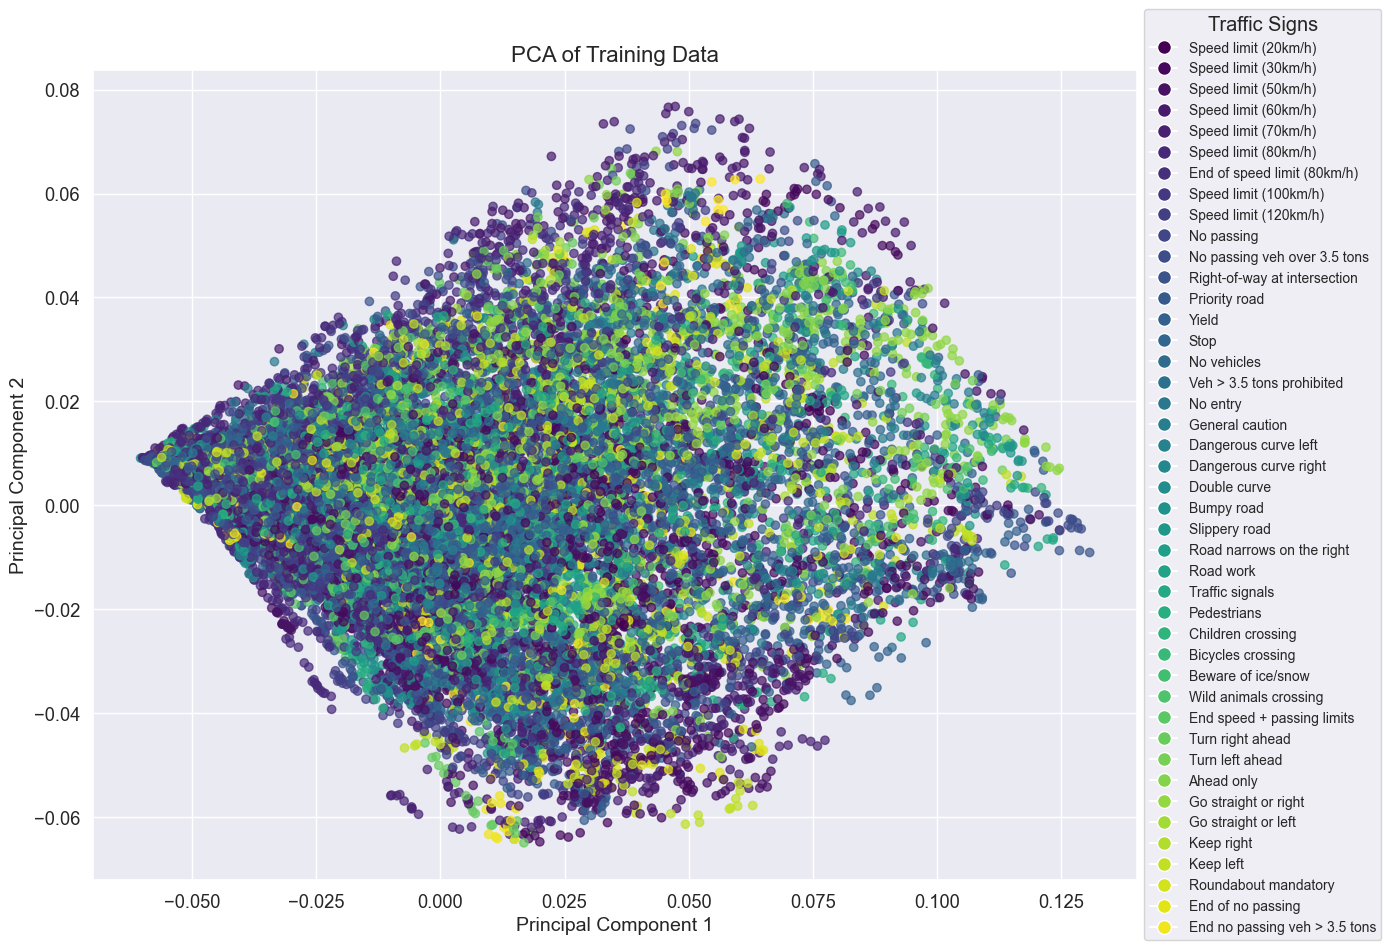

In [128]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 将训练集图像数据展平为一维向量
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # 将每张图片展平
X_train_scaled = X_train_flattened / 255  # 归一化处理

# 使用PCA降到二维
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# 绘制PCA可视化
plt.figure(figsize=(12, 10))

# 创建散点图，点的颜色根据类别来指定
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.7)

# 创建一个图例
handles, labels = [], []
for i in range(len(classes)):
    # 创建每个类别的图例条目
    handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(classes)), markersize=10, label=classes[i])
    handles.append(handle)
    labels.append(classes[i])

# 将图例添加到右侧
plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Traffic Signs', fontsize=10)


# 添加标题和标签
plt.title('PCA of Training Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# 显示图像
plt.show()


C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\QianBoda\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


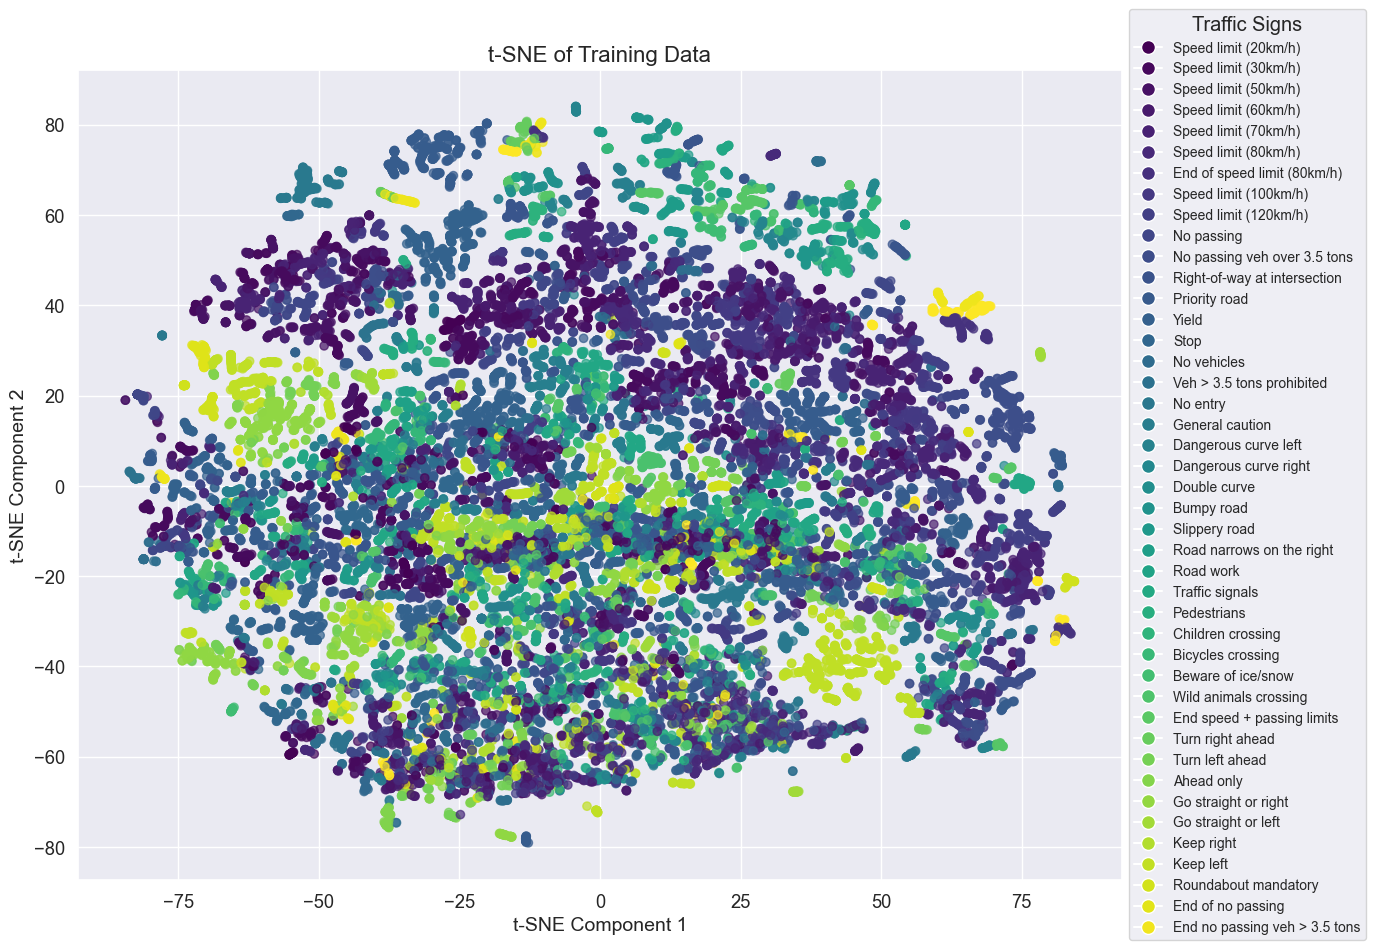

In [129]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 使用t-SNE对训练集数据降维
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)

# 绘制t-SNE可视化
plt.figure(figsize=(12, 10))

# 创建散点图，点的颜色根据类别来指定
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', alpha=0.7)

# 创建一个图例
handles, labels = [], []
for i in range(len(classes)):
    # 创建每个类别的图例条目
    handle = plt.Line2D([], [], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(classes)), markersize=10, label=classes[i])
    handles.append(handle)
    labels.append(classes[i])

# 将图例添加到右侧
plt.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Traffic Signs', fontsize=10)

# 添加标题和标签
plt.title('t-SNE of Training Data', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)

# 显示图像
plt.show()


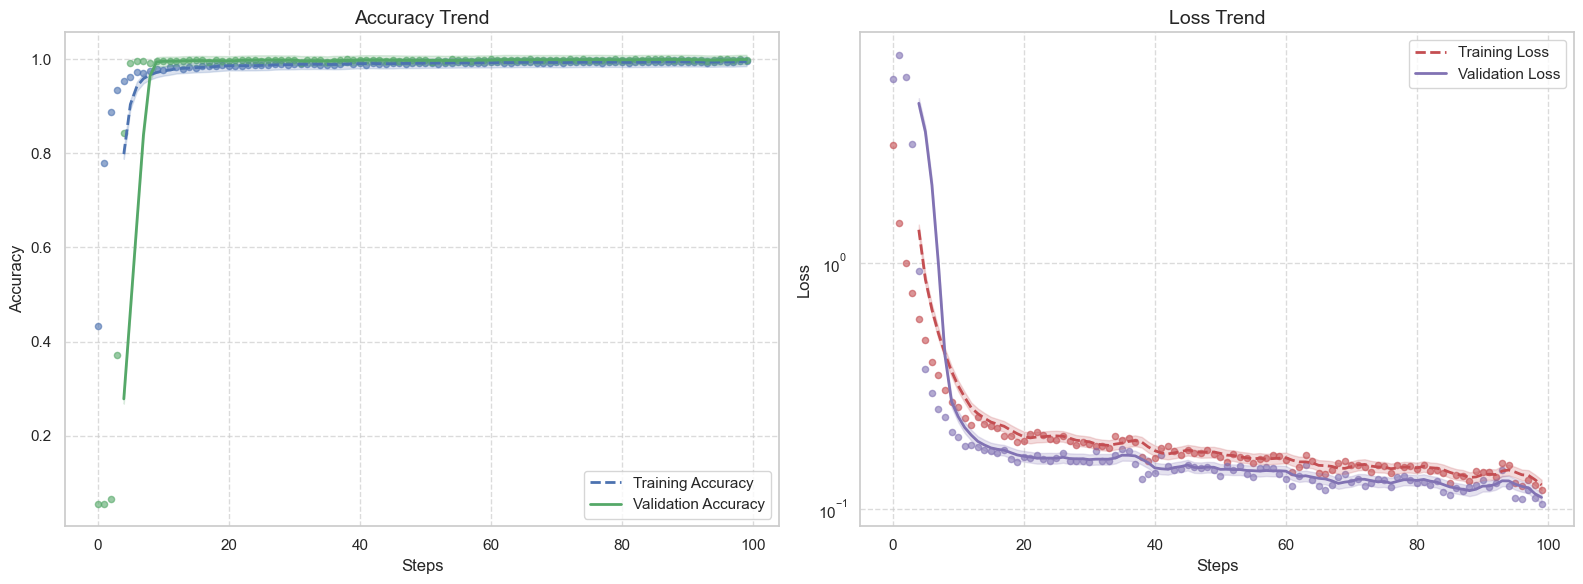

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 样式
sns.set(style="whitegrid")

# 读取数据
acc_train = pd.read_csv("data/acc_train.csv")
acc_val = pd.read_csv("data/acc_val.csv")
loss_train = pd.read_csv("data/loss_train.csv")
loss_val = pd.read_csv("data/loss_val.csv")

# 提取步骤和数值列
steps = acc_train['Step']
train_accuracy = acc_train['Value']
val_accuracy = acc_val['Value']
train_loss = loss_train['Value']
val_loss = loss_val['Value']

# 使用滚动平均平滑曲线
window_size = 5
train_accuracy_smooth = train_accuracy.rolling(window=window_size).mean()
val_accuracy_smooth = val_accuracy.rolling(window=window_size).mean()
train_loss_smooth = train_loss.rolling(window=window_size).mean()
val_loss_smooth = val_loss.rolling(window=window_size).mean()

# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 绘制准确率曲线图
axes[0].plot(steps, train_accuracy_smooth, label="Training Accuracy", color="#4c72b0", linestyle="--", linewidth=2)
axes[0].plot(steps, val_accuracy_smooth, label="Validation Accuracy", color="#55a868", linewidth=2)
# 添加数据点
axes[0].scatter(steps, train_accuracy, color="#4c72b0", s=20, alpha=0.6, marker="o")
axes[0].scatter(steps, val_accuracy, color="#55a868", s=20, alpha=0.6, marker="o")
# 添加阴影区域
axes[0].fill_between(steps, train_accuracy_smooth - 0.01, train_accuracy_smooth + 0.01, color="#4c72b0", alpha=0.2)
axes[0].fill_between(steps, val_accuracy_smooth - 0.01, val_accuracy_smooth + 0.01, color="#55a868", alpha=0.2)
axes[0].set_xlabel("Steps", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].set_title("Accuracy Trend", fontsize=14)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.7)

# 绘制误差曲线图
axes[1].plot(steps, train_loss_smooth, label="Training Loss", color="#c44e52", linestyle="--", linewidth=2)
axes[1].plot(steps, val_loss_smooth, label="Validation Loss", color="#8172b3", linewidth=2)
# 添加数据点
axes[1].scatter(steps, train_loss, color="#c44e52", s=20, alpha=0.6, marker="o")
axes[1].scatter(steps, val_loss, color="#8172b3", s=20, alpha=0.6, marker="o")
# 添加阴影区域
axes[1].fill_between(steps, train_loss_smooth * 0.95, train_loss_smooth * 1.05, color="#c44e52", alpha=0.2)
axes[1].fill_between(steps, val_loss_smooth * 0.95, val_loss_smooth * 1.05, color="#8172b3", alpha=0.2)
axes[1].set_xlabel("Steps", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].set_yscale("log")  # 对数刻度
axes[1].set_title("Loss Trend", fontsize=14)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.7)

# 美化布局和显示
plt.tight_layout()
plt.show()


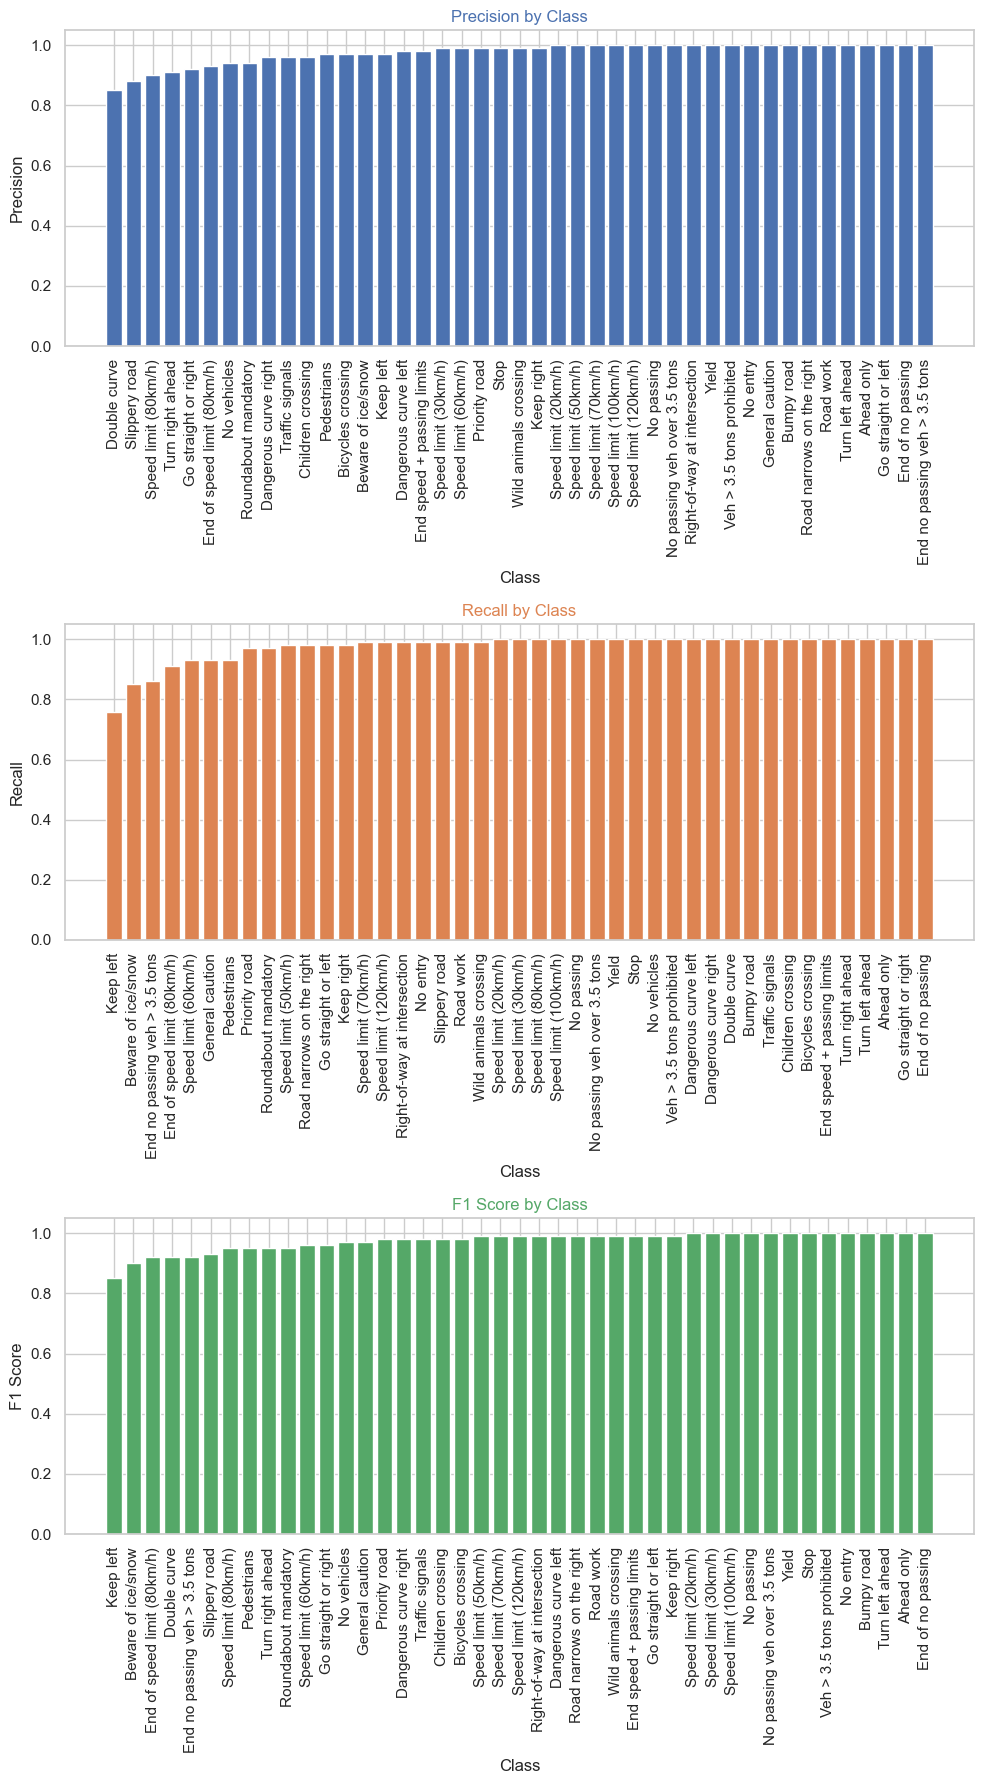

In [45]:
import re
import matplotlib.pyplot as plt

# 定义类别字典
classes = { 
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 17:'No entry', 18:'General caution', 
    19:'Dangerous curve left', 20:'Dangerous curve right', 21:'Double curve', 
    22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 
    28:'Children crossing', 29:'Bicycles crossing', 30:'Beware of ice/snow',
    31:'Wild animals crossing', 32:'End speed + passing limits', 33:'Turn right ahead', 
    34:'Turn left ahead', 35:'Ahead only', 36:'Go straight or right', 
    37:'Go straight or left', 38:'Keep right', 39:'Keep left', 
    40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}

# 初始化存储数据的列表
class_indices = []
precision = []
recall = []
f1_score = []

# 读取文件并提取数据
with open('./data/pr_re_f1.txt', 'r') as file:
    for line in file:
        match = re.match(r"\s*(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)", line)
        if match:
            class_index = int(match.group(1))
            class_indices.append(class_index)            # 类别索引
            precision.append(float(match.group(2)))      # 精度
            recall.append(float(match.group(3)))         # 召回率
            f1_score.append(float(match.group(4)))       # F1 分数

# 将类别索引转换为类别标签
class_labels = [classes[idx] for idx in class_indices]

# 创建字典列表，便于排序
data = list(zip(class_labels, precision, recall, f1_score))
data_sorted = sorted(data, key=lambda x: x[1])  # 按精度排序

# 解压排序后的数据
class_labels_sorted, precision_sorted, recall_sorted, f1_score_sorted = zip(*data_sorted)

# 定义颜色
precision_color = '#4C72B0'  # 蓝色
recall_color = '#DD8452'     # 橙色
f1_color = '#55A868'         # 绿色

# 创建可视化 3x1 的布局
fig, ax = plt.subplots(3, 1, figsize=(10, 18))

# 1. Precision
ax[0].bar(class_labels_sorted, precision_sorted, color=precision_color)
ax[0].set_title('Precision by Class', color=precision_color)
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Precision')
ax[0].tick_params(axis='x', rotation=90)

# 2. Recall
data_sorted = sorted(data, key=lambda x: x[2])  # 按召回率排序
class_labels_sorted, _, recall_sorted, _ = zip(*data_sorted)
ax[1].bar(class_labels_sorted, recall_sorted, color=recall_color)
ax[1].set_title('Recall by Class', color=recall_color)
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Recall')
ax[1].tick_params(axis='x', rotation=90)

# 3. F1 Score
data_sorted = sorted(data, key=lambda x: x[3])  # 按F1分数排序
class_labels_sorted, _, _, f1_score_sorted = zip(*data_sorted)
ax[2].bar(class_labels_sorted, f1_score_sorted, color=f1_color)
ax[2].set_title('F1 Score by Class', color=f1_color)
ax[2].set_xlabel('Class')
ax[2].set_ylabel('F1 Score')
ax[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
